In [3]:
import pandas as pd

# Load the Excel file
file_path = 'D34567.xlsx'
df = pd.read_excel(file_path, sheet_name='Normalized')

# Extract the treatment conditions from the column headers (excluding the first column which is time)
treatment_conditions = df.columns[1:].tolist()

# Extract the time data from the first column
time_data = df.iloc[:, 0]

# Extract the wound area data (all columns except the first)
wound_area_data = df.iloc[:, 1:]

# Create a properly structured DataFrame with time as index and treatment conditions as columns
wound_area_df = pd.DataFrame(wound_area_data.values, columns=treatment_conditions, index=time_data)

# Set the index name for clarity
wound_area_df.index.name = 'Time (Hours)'

# Display basic information about the dataset
print(f"Dataset shape: {wound_area_df.shape}")
print(f"Time points: {len(wound_area_df.index)}")
print(f"Number of samples: {len(wound_area_df.columns)}")
print(f"Time range: {wound_area_df.index.min()} to {wound_area_df.index.max()} hours")

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(wound_area_df.head())

# Display the treatment conditions
print(f"\nTreatment conditions (first 10): {treatment_conditions[:10]}")


Dataset shape: (44, 239)
Time points: 44
Number of samples: 239
Time range: 0 to 43 hours

First 5 rows of the dataset:
              Cisplatin_10  Cisplatin_11  Cisplatin_12  Cisplatin_13  \
Time (Hours)                                                           
0                 1.000000      1.000000      1.000000      1.000000   
1                 1.094394      1.128039      1.219720      1.165707   
2                 1.178000      1.169772      1.412383      1.256836   
3                 1.238572      1.205751      1.647570      1.184944   
4                 1.294174      1.247106      1.666916      1.182467   

              Cisplatin_16  Cisplatin_17  Cisplatin_18  Cisplatin_19  \
Time (Hours)                                                           
0                 1.000000      1.000000      1.000000      1.000000   
1                 1.330844      1.382196      1.256508      1.671257   
2                 1.427271      1.536812      1.439069      1.771787   
3              

In [4]:
import numpy as np
import re

# Extract condition names from column headers
def extract_condition_name(sample_name):
    match = re.match(r'([^_]+)', sample_name)
    if match:
        return match.group(1)
    return sample_name

# Transform wide format to long format
df_long = wound_area_df.reset_index().melt(
    id_vars=['Time (Hours)'],
    var_name='Well',
    value_name='Area'
)

# Extract condition names
df_long['Condition_Name'] = df_long['Well'].apply(extract_condition_name)


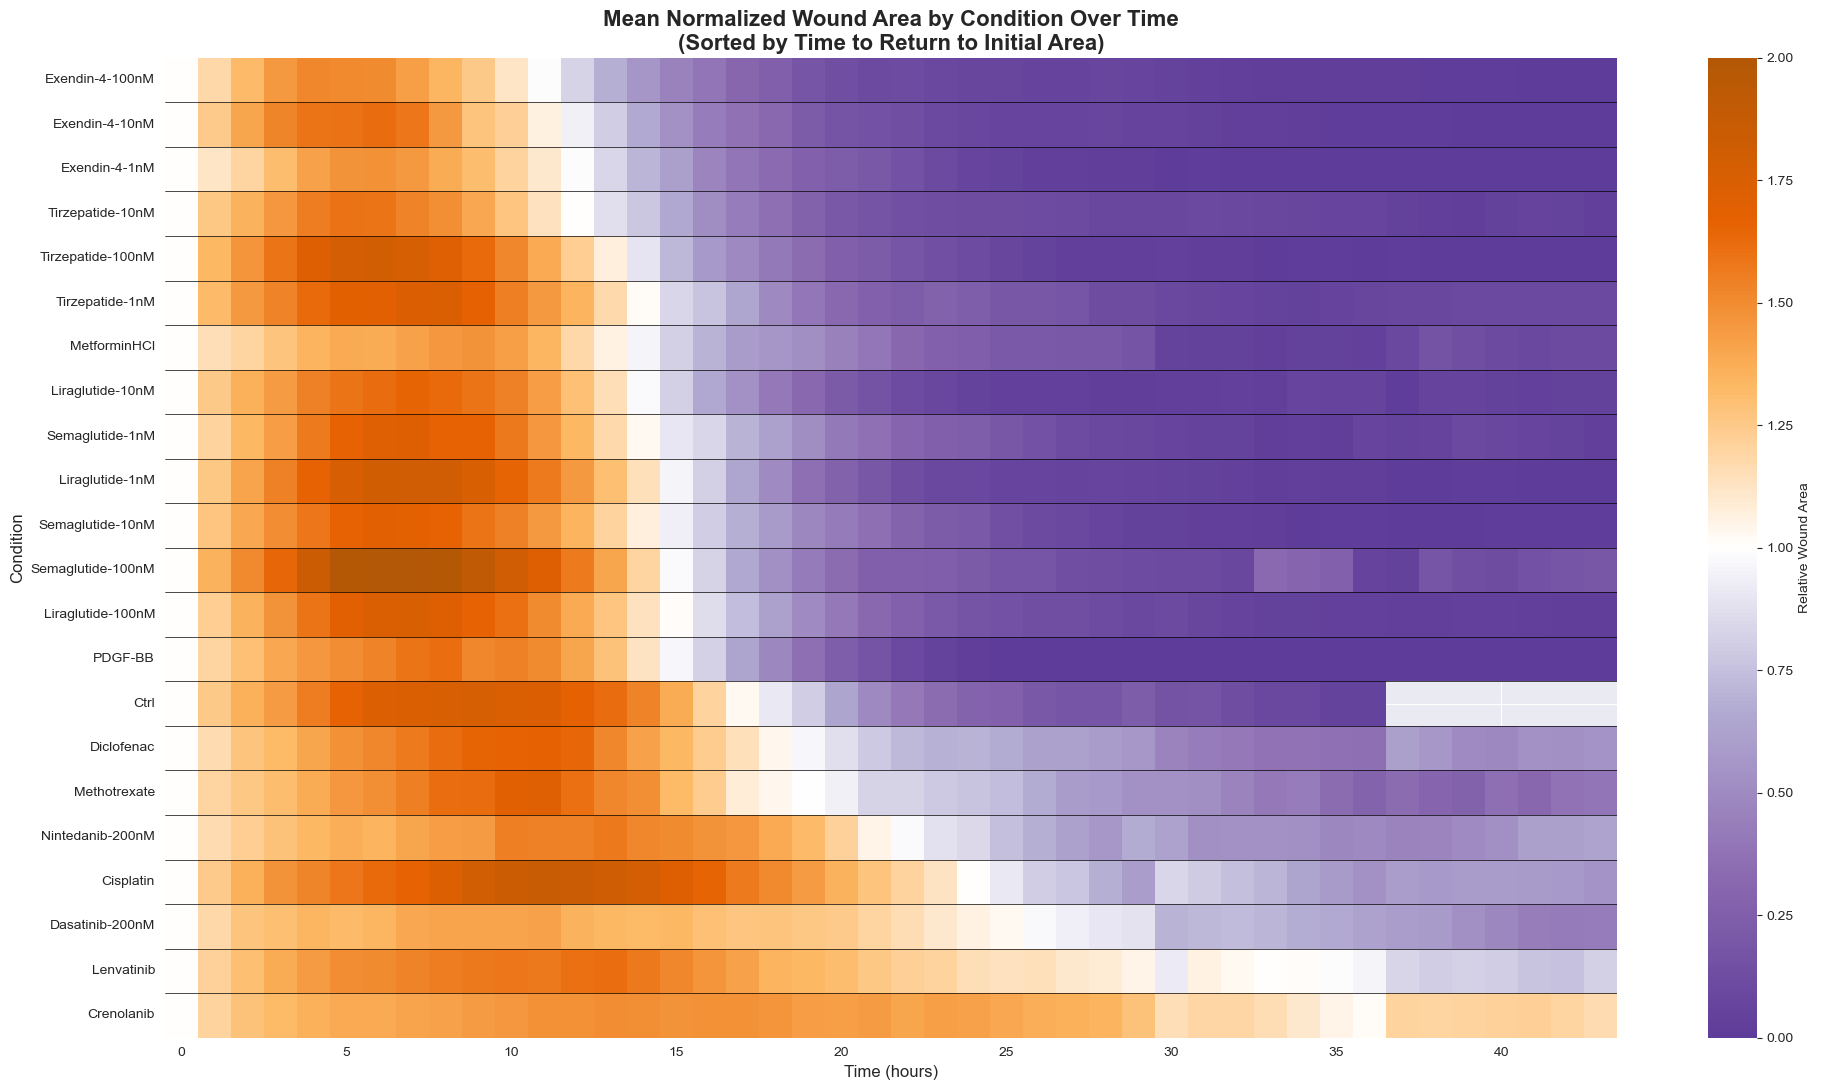

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# First transform the long format back to wide format for the heatmap
# Get mean value for each condition and time point
condition_means = df_long.groupby(['Condition_Name', 'Time (Hours)'])['Area'].mean().reset_index()

# Create a pivot table with conditions as rows and time as columns
heatmap_data = condition_means.pivot(index='Condition_Name', columns='Time (Hours)', values='Area')

# Calculate time to return to initial area for sorting conditions
def time_to_return_initial(row):
    """Find the time point where the wound returns closest to its initial area (value of 1)"""
    if all(val > 1 for val in row):  # If all values are above 1
        return np.inf

    # Find the point closest to 1.0 after the maximum
    max_idx = row.argmax()
    later_points = row.iloc[max_idx:]
    if len(later_points) <= 1:
        return np.inf

    # Find index of value closest to 1.0
    closest_idx = (np.abs(later_points - 1.0)).argmin() + max_idx
    return row.index[closest_idx]

# Apply the function to sort conditions
healing_times = heatmap_data.apply(time_to_return_initial, axis=1)
sorted_conditions = healing_times.sort_values().index.tolist()

# Reindex the heatmap data to sort conditions
heatmap_data_sorted = heatmap_data.reindex(sorted_conditions)

# Create a custom colormap (purple to white to orange)
colors_below = ['#5e3c99', '#8c6bb1', '#b2abd2']  # purple shades (wound expanded)
colors_above = ['#fdb863', '#e66101', '#b35806']  # orange shades (wound closing)
colors_list = colors_below + ['#ffffff'] + colors_above
cmap = LinearSegmentedColormap.from_list('purple_white_orange', colors_list, N=256)

# Create a normalization that puts the center at 1.0
norm = TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=2.0)

# Create a figure and heatmap
plt.figure(figsize=(20, len(sorted_conditions) * 0.5))
ax = sns.heatmap(heatmap_data_sorted,
                cmap=cmap,
                norm=norm,
                cbar_kws={'label': 'Relative Wound Area'},
                xticklabels=5,  # Show every 5th time tick
                yticklabels=True)

# Add horizontal line markers for conditions
for i in range(1, len(sorted_conditions)):
    plt.axhline(y=i, color='black', linestyle='-', linewidth=0.5)

plt.title('Mean Normalized Wound Area by Condition Over Time\n(Sorted by Time to Return to Initial Area)',
          fontsize=16, fontweight='bold')
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Condition', fontsize=12)
plt.tight_layout()
plt.savefig('condition_means_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

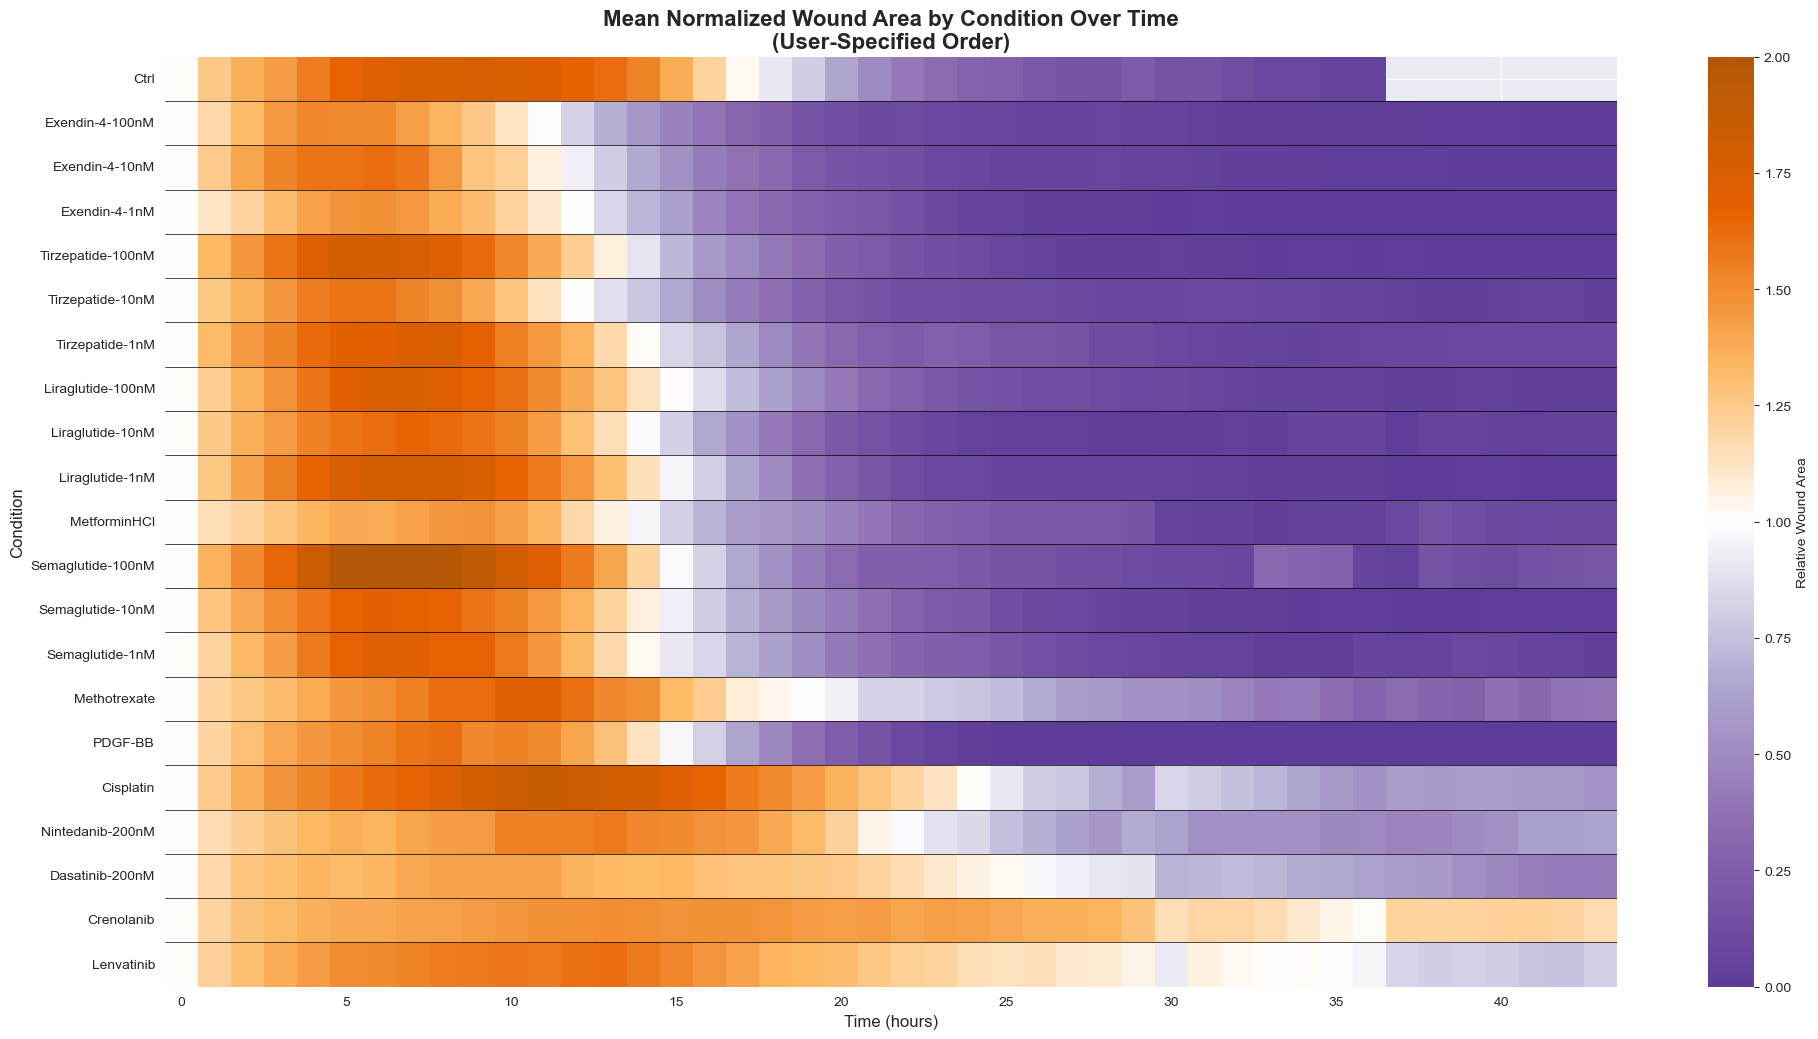


Conditions plotted in the heatmap (in order):
Ctrl
Exendin-4-100nM
Exendin-4-10nM
Exendin-4-1nM
Tirzepatide-100nM
Tirzepatide-10nM
Tirzepatide-1nM
Liraglutide-100nM
Liraglutide-10nM
Liraglutide-1nM
MetforminHCl
Semaglutide-100nM
Semaglutide-10nM
Semaglutide-1nM
Methotrexate
PDGF-BB
Cisplatin
Nintedanib-200nM
Dasatinib-200nM
Crenolanib
Lenvatinib

For reference, some conditions in your data NOT in your specified list (max 20 shown):
- Diclofenac


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

user_specified_condition_order = [
    'Ctrl',
    'Exendin-4-100nM',
    'Exendin-4-10nM',
    'Exendin-4-1nM',
    'Tirzepatide-100nM',
    'Tirzepatide-10nM',
    'Tirzepatide-1nM',
    'Liraglutide-100nM',
    'Liraglutide-10nM',
    'Liraglutide-1nM',
    'MetforminHCl',
    'Semaglutide-100nM',
    'Semaglutide-10nM',
    'Semaglutide-1nM',
    'Methotrexate',
    'PDGF-BB',
    'Cisplatin',
    'Nintedanib-200nM',
    'Dasatinib-200nM',
    'Crenolanib',
    'Lenvatinib'
]

# # Calculate condition means from df_long
# # This ensures 'Condition_Name' is consistent with how it's defined in df_long
# condition_means = df_long.groupby(['Condition_Name', 'Time (Hours)'])['Area'].mean().reset_index()
# heatmap_data = condition_means.pivot(index='Condition_Name', columns='Time (Hours)', values='Area')

# Filter the user_specified_condition_order to include only conditions present in the heatmap_data
# This maintains the specified order for existing conditions.
# Conditions in user_specified_condition_order not found in heatmap_data.index will be omitted.
ordered_conditions_for_plot = [
    cond for cond in user_specified_condition_order if cond in heatmap_data.index
]

# If no conditions from the user list are found in the data, this list will be empty.
if not ordered_conditions_for_plot:
    print("Warning: None of the specified conditions were found in the data. Heatmap will be empty or show all data if not filtered.")
    # Fallback or error handling: decide whether to plot all data or an empty plot
    # For now, we'll proceed, and if ordered_conditions_for_plot is empty, reindex will result in an empty DataFrame.
    heatmap_data_ordered = pd.DataFrame() # Or heatmap_data.reindex([])
else:
    # Reindex the heatmap data according to the filtered and specified order
    heatmap_data_ordered = heatmap_data.reindex(ordered_conditions_for_plot)

# Create a custom colormap (purple to white to orange)
colors_below = ['#5e3c99', '#8c6bb1', '#b2abd2']
colors_above = ['#fdb863', '#e66101', '#b35806']
colors_list = colors_below + ['#ffffff'] + colors_above
cmap = LinearSegmentedColormap.from_list('purple_white_orange', colors_list, N=256)
norm = TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=2.0) # Adjust vmin, vcenter, vmax as needed

# Create the heatmap
plt.figure(figsize=(20, len(ordered_conditions_for_plot) * 0.5 if ordered_conditions_for_plot else 10))
if not heatmap_data_ordered.empty:
    ax = sns.heatmap(heatmap_data_ordered,
                    cmap=cmap,
                    norm=norm,
                    cbar_kws={'label': 'Relative Wound Area'},
                    xticklabels=5,
                    yticklabels=True)

    # Add horizontal line markers for conditions
    for i in range(1, len(ordered_conditions_for_plot)):
        plt.axhline(y=i, color='black', linestyle='-', linewidth=0.5)

    plt.title('Mean Normalized Wound Area by Condition Over Time\n(User-Specified Order)',
              fontsize=16, fontweight='bold')
    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('Condition', fontsize=12)
else:
    plt.title('No Data to Display for Specified Conditions', fontsize=16, fontweight='bold')
    print("Heatmap cannot be generated as no specified conditions were found in the data or data is empty.")


plt.tight_layout()
plt.savefig('condition_means_heatmap_user_specified_order.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConditions plotted in the heatmap (in order):")
if ordered_conditions_for_plot:
    for cond in ordered_conditions_for_plot:
        print(cond)
else:
    print("No conditions were plotted.")

# For debugging: Check which specified conditions were not found in the data
if heatmap_data is not None and not heatmap_data.empty:
    all_data_conditions = set(heatmap_data.index)
    specified_conditions_set = set(user_specified_condition_order)

    missing_from_data = [cond for cond in user_specified_condition_order if cond not in all_data_conditions]
    if missing_from_data:
        print("\nThe following specified conditions were NOT found in the dataset's Condition_Name column:")
        for cond in missing_from_data:
            print(f"- {cond}")

    not_in_spec_but_in_data = [cond for cond in all_data_conditions if cond not in specified_conditions_set]
    if not_in_spec_but_in_data and len(not_in_spec_but_in_data) < 20: # Print only if the list isn't too long
        print("\nFor reference, some conditions in your data NOT in your specified list (max 20 shown):")
        for cond in not_in_spec_but_in_data[:20]:
            print(f"- {cond}")
    elif not_in_spec_but_in_data:
        print(f"\nFor reference, there are {len(not_in_spec_but_in_data)} conditions in your data that were not in your specified list.")

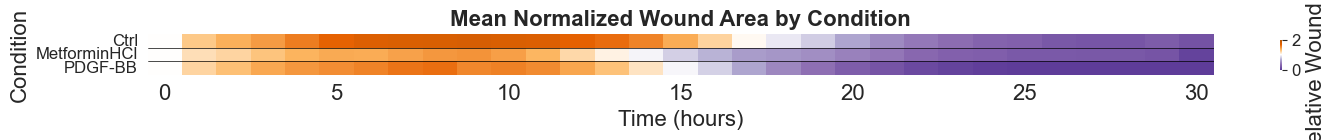


Conditions plotted in the heatmap (in order, data truncated at 30 hours):
Ctrl
MetforminHCl
PDGF-BB

For reference, some conditions in your truncated data NOT in your specified list (max 20 shown):
- Tirzepatide-100nM
- Dasatinib-200nM
- Liraglutide-100nM
- Tirzepatide-10nM
- Nintedanib-200nM
- Exendin-4-100nM
- Diclofenac
- Liraglutide-10nM
- Semaglutide-1nM
- Semaglutide-100nM
- Liraglutide-1nM
- Lenvatinib
- Methotrexate
- Semaglutide-10nM
- Tirzepatide-1nM
- Cisplatin
- Crenolanib
- Exendin-4-10nM
- Exendin-4-1nM


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import re


# Define the desired order of conditions
user_specified_condition_order = [
    'Ctrl',

    'MetforminHCl',
    'PDGF-BB'
]

# Truncate data at 30 hours
df_long_truncated = df_long[df_long['Time (Hours)'] <= 30].copy()

# Calculate condition means from the truncated df_long
condition_means = df_long_truncated.groupby(['Condition_Name', 'Time (Hours)'])['Area'].mean().reset_index()
heatmap_data = condition_means.pivot(index='Condition_Name', columns='Time (Hours)', values='Area')

# Filter the user_specified_condition_order to include only conditions present in the heatmap_data
ordered_conditions_for_plot = [
    cond for cond in user_specified_condition_order if cond in heatmap_data.index
]

if not ordered_conditions_for_plot:
    print("Warning: None of the specified conditions were found in the data. Heatmap will be empty or show all data if not filtered.")
    heatmap_data_ordered = pd.DataFrame()
else:
    heatmap_data_ordered = heatmap_data.reindex(ordered_conditions_for_plot)

# Create a custom colormap
colors_below = ['#5e3c99', '#8c6bb1', '#b2abd2']
colors_above = ['#fdb863', '#e66101', '#b35806']
colors_list = colors_below + ['#ffffff'] + colors_above
cmap = LinearSegmentedColormap.from_list('purple_white_orange', colors_list, N=256)
norm = TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=2.0)

# Create the heatmap
plt.figure(figsize=(15, len(ordered_conditions_for_plot) * 0.5 if ordered_conditions_for_plot else 10)) # Adjusted figsize for potentially fewer time points
if not heatmap_data_ordered.empty:
    ax = sns.heatmap(heatmap_data_ordered,
                    cmap=cmap,
                    norm=norm,
                    cbar_kws={'label': 'Relative Wound Area', 'shrink': 0.75}, # Added shrink for better layout with larger label
                    xticklabels=5 if heatmap_data_ordered.shape[1] > 5 else 1, # Adjust xticklabels based on number of columns
                    yticklabels=True)
    # Increase font size for x and y tick labels
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=12)

     # Increase font size for color bar label
    cbar = ax.collections[0].colorbar
    cbar.set_label('Relative Wound Area', size=16)
    cbar.ax.tick_params(labelsize=12) # Increase font size of cbar tick labels



    for i in range(1, len(ordered_conditions_for_plot)):
        plt.axhline(y=i, color='black', linestyle='-', linewidth=0.5)

    plt.title('Mean Normalized Wound Area by Condition',
              fontsize=16, fontweight='bold')
    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Condition', fontsize=16)
else:
    plt.title('No Data to Display for Specified Conditions (Up to 30 Hours)', fontsize=16, fontweight='bold')
    print("Heatmap cannot be generated as no specified conditions were found in the truncated data or data is empty.")

plt.tight_layout()
plt.savefig('condition_means_heatmap_user_specified_order_truncated_30h.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConditions plotted in the heatmap (in order, data truncated at 30 hours):")
if ordered_conditions_for_plot:
    for cond in ordered_conditions_for_plot:
        print(cond)
else:
    print("No conditions were plotted.")

if heatmap_data is not None and not heatmap_data.empty:
    all_data_conditions = set(heatmap_data.index)
    specified_conditions_set = set(user_specified_condition_order)

    missing_from_data = [cond for cond in user_specified_condition_order if cond not in all_data_conditions]
    if missing_from_data:
        print("\nThe following specified conditions were NOT found in the dataset (after truncating at 30h):")
        for cond in missing_from_data:
            print(f"- {cond}")

    not_in_spec_but_in_data = [cond for cond in all_data_conditions if cond not in specified_conditions_set]
    if not_in_spec_but_in_data and len(not_in_spec_but_in_data) < 20:
        print("\nFor reference, some conditions in your truncated data NOT in your specified list (max 20 shown):")
        for cond in not_in_spec_but_in_data[:20]:
            print(f"- {cond}")
    elif not_in_spec_but_in_data:
        print(f"\nFor reference, there are {len(not_in_spec_but_in_data)} conditions in your truncated data that were not in your specified list.")

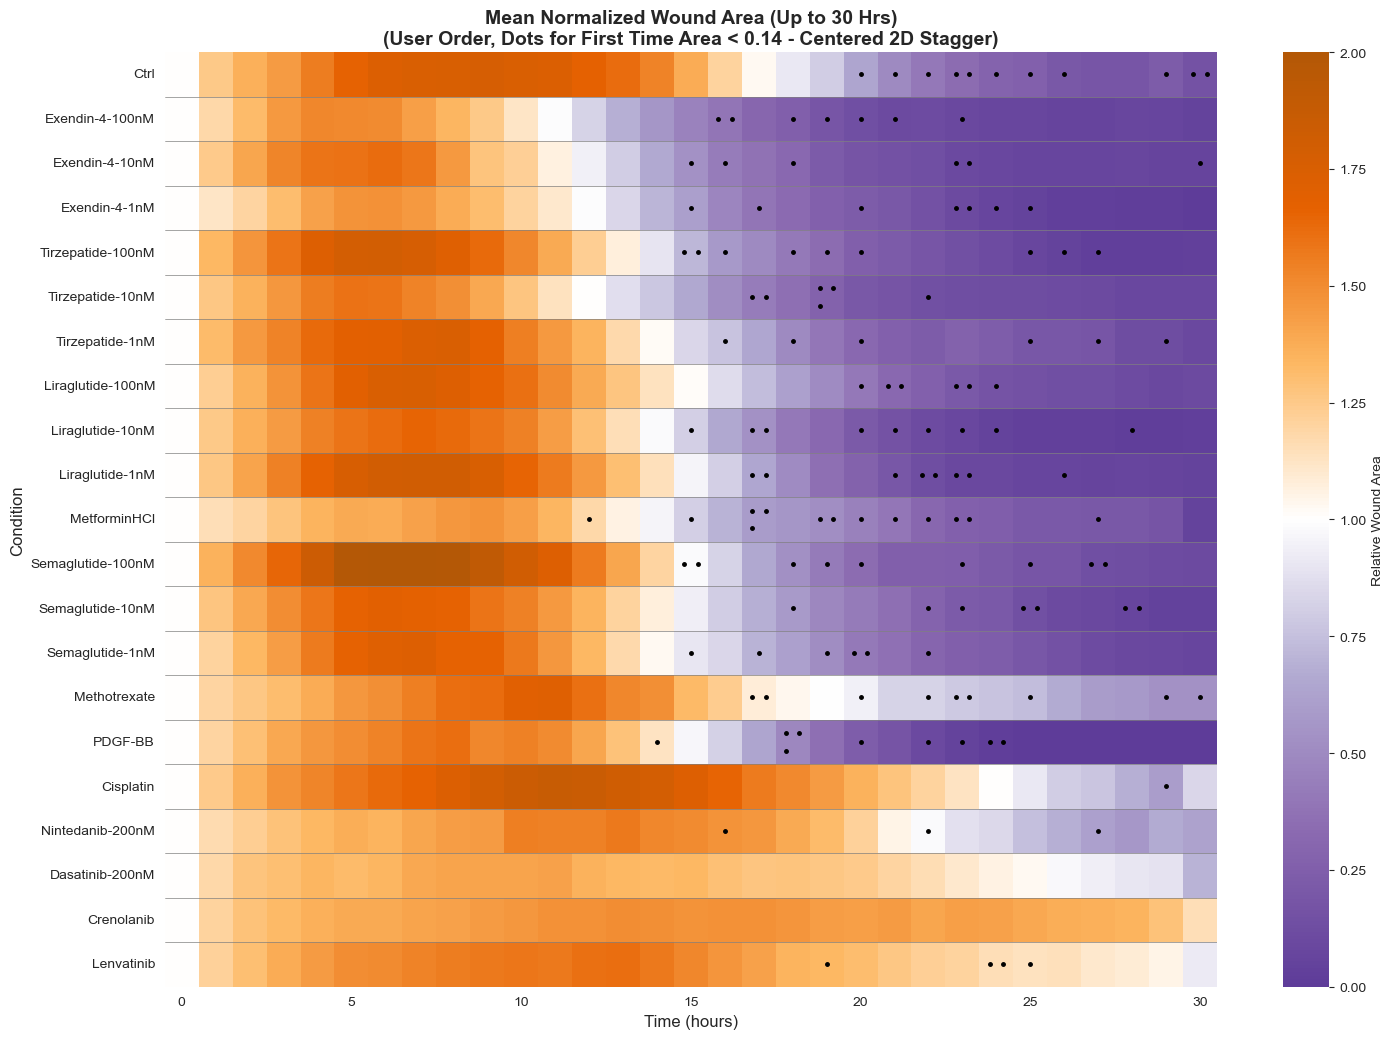


Conditions plotted in the heatmap (in order, data truncated at 30 hours):
Ctrl
Exendin-4-100nM
Exendin-4-10nM
Exendin-4-1nM
Tirzepatide-100nM
Tirzepatide-10nM
Tirzepatide-1nM
Liraglutide-100nM
Liraglutide-10nM
Liraglutide-1nM
MetforminHCl
Semaglutide-100nM
Semaglutide-10nM
Semaglutide-1nM
Methotrexate
PDGF-BB
Cisplatin
Nintedanib-200nM
Dasatinib-200nM
Crenolanib
Lenvatinib

For reference, some conditions in your truncated data NOT in your specified list (max 20 shown):
- Diclofenac

Number of unique samples that dropped below 0.5 Area (first instance): 148


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import re # Ensure re is imported if extract_condition_name is used

# Assuming df_long is already created from previous cells and contains
# 'Time (Hours)', 'Condition_Name', 'Well', and 'Area'.
# The 'Condition_Name' in df_long should match the entries in user_specified_condition_order.
# Make sure df_long is available from previous cells in your notebook.
# Example:
# file_path = 'D:\\PythonProjects\\DataPlotting\\Data\\D34567.xlsx'
# df_excel = pd.read_excel(file_path, sheet_name='Normalized')
# treatment_conditions = df_excel.columns[1:].tolist()
# time_data = df_excel.iloc[:, 0]
# wound_area_data = df_excel.iloc[:, 1:]
# wound_area_df = pd.DataFrame(wound_area_data.values, columns=treatment_conditions, index=time_data)
# wound_area_df.index.name = 'Time (Hours)'
# def extract_condition_name(sample_name):
#     # This function should correctly parse 'Well' names to 'Condition_Name'
#     # e.g., 'Ctrl_A1' -> 'Ctrl', 'Exendin-4-100nM_B1' -> 'Exendin-4-100nM'
#     # The definition of this function should be present in your notebook before this cell.
#     full_match = re.match(r'([A-Za-z0-9\-]+(?:-[0-9\.]+nM)?)', sample_name)
#     if full_match:
#         return full_match.group(1)
#     simple_match = re.match(r'([^_]+)', sample_name) # Fallback
#     if simple_match:
#         return simple_match.group(1)
#     return sample_name
#
# df_long = wound_area_df.reset_index().melt(
#     id_vars=['Time (Hours)'],
#     var_name='Well',
#     value_name='Area'
# )
# df_long['Condition_Name'] = df_long['Well'].apply(extract_condition_name)
# # Ensure df_long is available and correctly processed before this cell.

# Define the desired order of conditions
user_specified_condition_order = [
    'Ctrl',
    'Exendin-4-100nM',
    'Exendin-4-10nM',
    'Exendin-4-1nM',
    'Tirzepatide-100nM',
    'Tirzepatide-10nM',
    'Tirzepatide-1nM',
    'Liraglutide-100nM',
    'Liraglutide-10nM',
    'Liraglutide-1nM',
    'MetforminHCl',
    'Semaglutide-100nM',
    'Semaglutide-10nM',
    'Semaglutide-1nM',
    'Methotrexate',
    'PDGF-BB',
    'Cisplatin',
    'Nintedanib-200nM',
    'Dasatinib-200nM',
    'Crenolanib',
    'Lenvatinib'
]

# Truncate data at 30 hours
# Ensure df_long is defined from previous cells and has 'Time (Hours)', 'Condition_Name', 'Area', 'Well'
df_long_truncated = df_long[df_long['Time (Hours)'] <= 30].copy()

# Calculate condition means from the truncated df_long for the heatmap background
condition_means = df_long_truncated.groupby(['Condition_Name', 'Time (Hours)'])['Area'].mean().reset_index()
heatmap_data = condition_means.pivot(index='Condition_Name', columns='Time (Hours)', values='Area')

# Filter the user_specified_condition_order to include only conditions present in the heatmap_data
ordered_conditions_for_plot = [
    cond for cond in user_specified_condition_order if cond in heatmap_data.index
]

if not ordered_conditions_for_plot:
    print("Warning: None of the specified conditions were found in the data. Heatmap will be empty or show all data if not filtered.")
    heatmap_data_ordered = pd.DataFrame()
else:
    heatmap_data_ordered = heatmap_data.reindex(ordered_conditions_for_plot)

# Create a custom colormap
colors_below = ['#5e3c99', '#8c6bb1', '#b2abd2']
colors_above = ['#fdb863', '#e66101', '#b35806']
colors_list = colors_below + ['#ffffff'] + colors_above
cmap = LinearSegmentedColormap.from_list('purple_white_orange', colors_list, N=256)
norm = TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=2.0)

# Create the heatmap
plt.figure(figsize=(15, len(ordered_conditions_for_plot) * 0.5 if ordered_conditions_for_plot else 10))
if not heatmap_data_ordered.empty:
    ax = sns.heatmap(heatmap_data_ordered,
                    cmap=cmap,
                    norm=norm,
                    cbar_kws={'label': 'Relative Wound Area'},
                    xticklabels=5 if heatmap_data_ordered.shape[1] > 5 else 1,
                    yticklabels=True)

    # Add horizontal line markers for conditions
    for i in range(1, len(ordered_conditions_for_plot)):
        plt.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)

    # Identify the first instance each sample drops below 0.14
    samples_below_threshold = df_long_truncated[df_long_truncated['Area'] < 0.14]

    if not samples_below_threshold.empty:
        critical_individual_samples = samples_below_threshold.loc[
            samples_below_threshold.groupby('Well')['Time (Hours)'].idxmin()
        ]
    else:
        critical_individual_samples = pd.DataFrame()


    if not critical_individual_samples.empty:
        condition_to_y_idx = {condition: i for i, condition in enumerate(ordered_conditions_for_plot)}
        time_values_on_heatmap = heatmap_data_ordered.columns
        time_to_x_idx = {time_val: i for i, time_val in enumerate(time_values_on_heatmap)}

        grouped_critical_samples = critical_individual_samples.groupby(['Condition_Name', 'Time (Hours)'])

        for (condition, time_val), group_df in grouped_critical_samples:
            if condition in condition_to_y_idx and time_val in time_to_x_idx:
                y_idx_base = condition_to_y_idx[condition]
                x_idx_base = time_to_x_idx[time_val]

                num_dots_in_cell = len(group_df)

                if num_dots_in_cell > 0:
                    num_cols_stagger = int(np.ceil(np.sqrt(num_dots_in_cell)))
                    num_rows_stagger = int(np.ceil(num_dots_in_cell / num_cols_stagger))
                    if num_rows_stagger == 0: num_rows_stagger = 1
                    if num_cols_stagger == 0: num_cols_stagger = 1

                    # Define the range for staggering (e.g., 0.3 to 0.7 of cell width/height)
                    stagger_min_offset = 0.3
                    stagger_max_offset = 0.7

                    for k in range(num_dots_in_cell):
                        col_k = k % num_cols_stagger
                        row_k = k // num_cols_stagger

                        offset_x = 0.5 # Default center
                        offset_y = 0.5 # Default center

                        if num_dots_in_cell > 1:
                            if num_cols_stagger > 1:
                                # Spread dots from stagger_min_offset to stagger_max_offset
                                offset_x = np.linspace(stagger_min_offset, stagger_max_offset, num_cols_stagger)[col_k]
                            else: # Single column of dots
                                offset_x = 0.5 # Center horizontally

                            if num_rows_stagger > 1:
                                # Spread dots from stagger_min_offset to stagger_max_offset
                                offset_y = np.linspace(stagger_min_offset, stagger_max_offset, num_rows_stagger)[row_k]
                            else: # Single row of dots
                                offset_y = 0.5 # Center vertically

                        # If only one dot, it's already centered by default offset_x=0.5, offset_y=0.5

                        dot_x = x_idx_base + offset_x
                        dot_y = y_idx_base + offset_y

                        ax.plot(dot_x, dot_y, 'o', color='black', markersize=2.5)

    plt.title('Mean Normalized Wound Area (Up to 30 Hrs)\n(User Order, Dots for First Time Area < 0.14 - Centered 2D Stagger)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('Condition', fontsize=12)
else:
    plt.title('No Data to Display for Specified Conditions (Up to 30 Hours)', fontsize=16, fontweight='bold')
    print("Heatmap cannot be generated as no specified conditions were found in the truncated data or data is empty.")

plt.tight_layout()
plt.savefig('condition_means_heatmap_user_order_truncated_30h_critical_dots_first_time_0.5_centered_2d_stagger.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConditions plotted in the heatmap (in order, data truncated at 30 hours):")
if ordered_conditions_for_plot:
    for cond in ordered_conditions_for_plot:
        print(cond)
else:
    print("No conditions were plotted.")

if 'heatmap_data' in locals() and heatmap_data is not None and not heatmap_data.empty:
    all_data_conditions = set(heatmap_data.index)
    specified_conditions_set = set(user_specified_condition_order)

    missing_from_data = [cond for cond in user_specified_condition_order if cond not in all_data_conditions]
    if missing_from_data:
        print("\nThe following specified conditions were NOT found in the dataset (after truncating at 30h):")
        for cond in missing_from_data:
            print(f"- {cond}")

    not_in_spec_but_in_data = [cond for cond in all_data_conditions if cond not in specified_conditions_set]
    if not_in_spec_but_in_data and len(not_in_spec_but_in_data) < 20:
        print("\nFor reference, some conditions in your truncated data NOT in your specified list (max 20 shown):")
        for cond in not_in_spec_but_in_data[:20]:
            print(f"- {cond}")
    elif not_in_spec_but_in_data:
        print(f"\nFor reference, there are {len(not_in_spec_but_in_data)} conditions in your truncated data that were not in your specified list.")

if not critical_individual_samples.empty:
    print(f"\nNumber of unique samples that dropped below 0.5 Area (first instance): {len(critical_individual_samples)}")
else:
    print("\nNo individual samples dropped below 0.5 Area within 30 hours.")

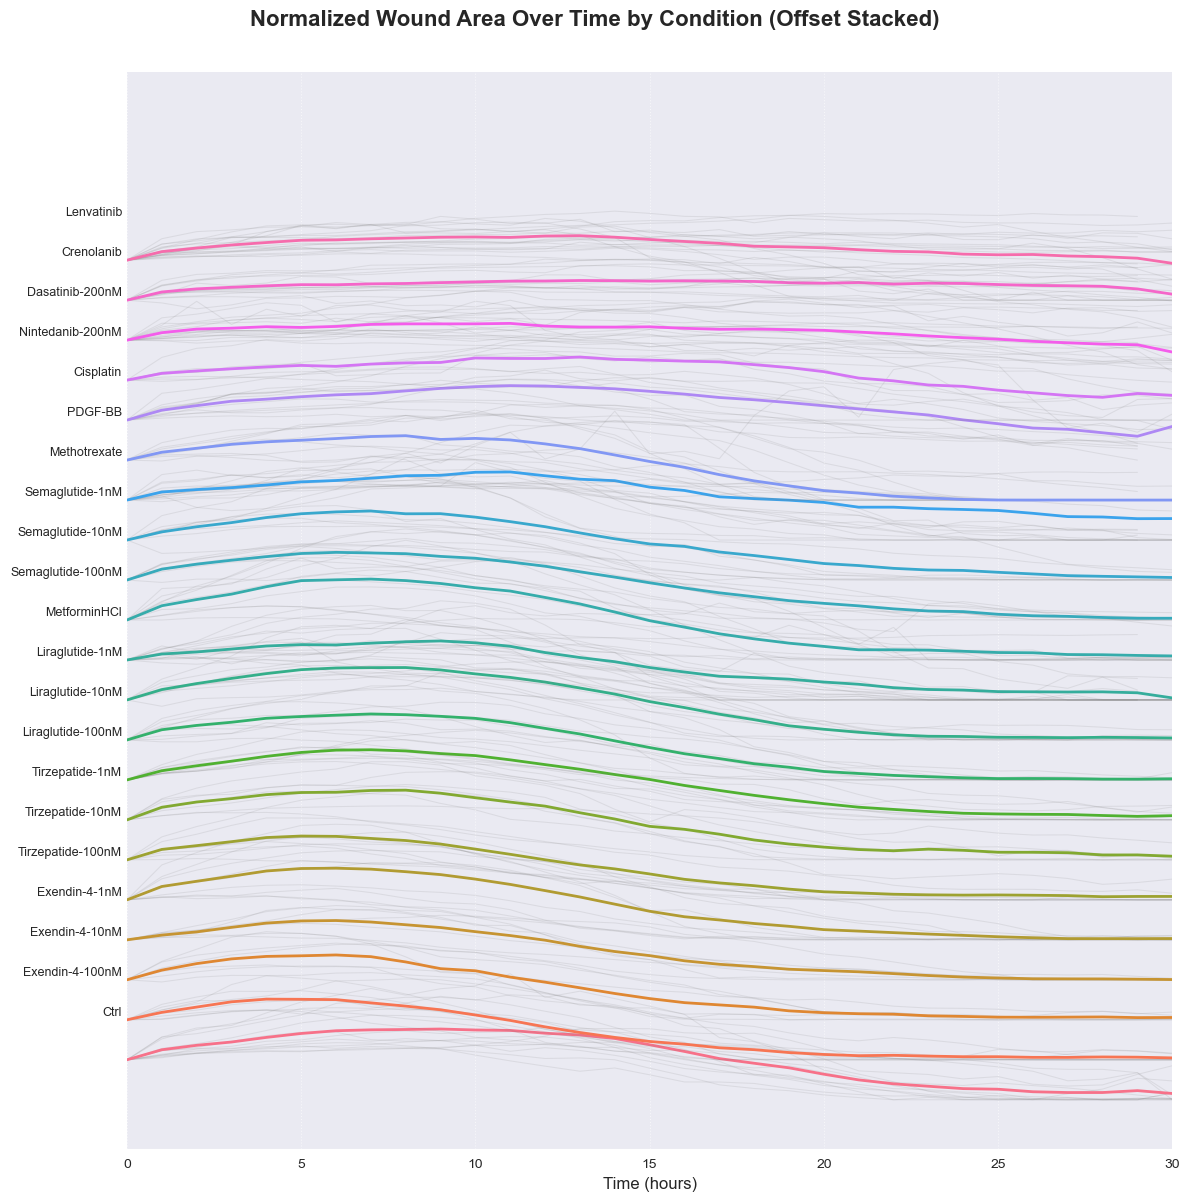


Conditions plotted (in order, bottom to top, data truncated at 30 hours):
Ctrl
Exendin-4-100nM
Exendin-4-10nM
Exendin-4-1nM
Tirzepatide-100nM
Tirzepatide-10nM
Tirzepatide-1nM
Liraglutide-100nM
Liraglutide-10nM
Liraglutide-1nM
MetforminHCl
Semaglutide-100nM
Semaglutide-10nM
Semaglutide-1nM
Methotrexate
PDGF-BB
Cisplatin
Nintedanib-200nM
Dasatinib-200nM
Crenolanib
Lenvatinib

For reference, some conditions in your truncated data NOT in your specified list (max 20 shown):
- Diclofenac


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For color palettes
import re

# Preamble: Assuming df_long needs to be prepared or is prepared with this logic.
# This ensures Condition_Name is parsed as expected by user_specified_condition_order.
file_path = 'D:\\PythonProjects\\DataPlotting\\Data\\D34567.xlsx' # Example file path
df_excel = pd.read_excel(file_path, sheet_name='Normalized')
treatment_conditions = df_excel.columns[1:].tolist()
time_data = df_excel.iloc[:, 0]
wound_area_data = df_excel.iloc[:, 1:]
wound_area_df = pd.DataFrame(wound_area_data.values, columns=treatment_conditions, index=time_data)
wound_area_df.index.name = 'Time (Hours)'

def extract_condition_name(sample_name):
    # This function should correctly parse 'Well' names to 'Condition_Name'
    # e.g., 'Ctrl_A1' -> 'Ctrl', 'Exendin-4-100nM_B1' -> 'Exendin-4-100nM'
    full_match = re.match(r'([A-Za-z0-9\-]+(?:-[0-9\.]+nM)?)', sample_name)
    if full_match:
        return full_match.group(1)
    simple_match = re.match(r'([^_]+)', sample_name) # Fallback
    if simple_match:
        return simple_match.group(1)
    return sample_name

df_long = wound_area_df.reset_index().melt(
    id_vars=['Time (Hours)'],
    var_name='Well',
    value_name='Area'
)
df_long['Condition_Name'] = df_long['Well'].apply(extract_condition_name)
# End of Preamble for df_long creation

# Define the desired order of conditions
user_specified_condition_order = [
    'Ctrl',
    'Exendin-4-100nM',
    'Exendin-4-10nM',
    'Exendin-4-1nM',
    'Tirzepatide-100nM',
    'Tirzepatide-10nM',
    'Tirzepatide-1nM',
    'Liraglutide-100nM',
    'Liraglutide-10nM',
    'Liraglutide-1nM',
    'MetforminHCl',
    'Semaglutide-100nM',
    'Semaglutide-10nM',
    'Semaglutide-1nM',
    'Methotrexate',
    'PDGF-BB',
    'Cisplatin',
    'Nintedanib-200nM',
    'Dasatinib-200nM',
    'Crenolanib',
    'Lenvatinib'
]

# Truncate data at 30 hours
df_long_truncated = df_long[df_long['Time (Hours)'] <= 30].copy()

# Filter the user_specified_condition_order to include only conditions present in the truncated data
available_conditions_in_data = df_long_truncated['Condition_Name'].unique()
ordered_conditions_for_plot = [
    cond for cond in user_specified_condition_order if cond in available_conditions_in_data
]

if not ordered_conditions_for_plot:
    print("Warning: None of the specified conditions were found in the truncated data. No plots will be generated.")
else:
    num_conditions = len(ordered_conditions_for_plot)
    vertical_offset_increment = 1.0  # Adjust for more or less overlap/spacing
                                     # Value of 1 means next plot starts where previous one's mean value of 1 would be

    fig_height = max(6, num_conditions * 0.6) # Adjust 0.6 factor for taller/shorter visual space per condition
    fig, ax = plt.subplots(figsize=(12, fig_height))

    palette = sns.color_palette("husl", num_conditions) # Get distinct colors for mean lines

    min_overall_area = df_long_truncated['Area'].min()
    max_overall_area = df_long_truncated['Area'].max()

    y_tick_positions = []
    y_tick_labels = []

    for i, condition_name in enumerate(ordered_conditions_for_plot):
        current_offset = i * vertical_offset_increment
        y_tick_positions.append(current_offset + (min_overall_area + max_overall_area) / 2) # Center label in data range
        y_tick_labels.append(condition_name)

        condition_data = df_long_truncated[df_long_truncated['Condition_Name'] == condition_name]

        # Plot individual well data
        for well in condition_data['Well'].unique():
            well_data = condition_data[condition_data['Well'] == well]
            ax.plot(well_data['Time (Hours)'], well_data['Area'] + current_offset,
                    color='grey', alpha=0.15, linewidth=0.75)

        # Plot mean data for the condition
        mean_condition_data = condition_data.groupby('Time (Hours)')['Area'].mean().reset_index()
        if not mean_condition_data.empty:
            ax.plot(mean_condition_data['Time (Hours)'], mean_condition_data['Area'] + current_offset,
                    color=palette[i], linewidth=2)

    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels, fontsize=9) # Adjust fontsize as needed

    # Style Y-axis for a cleaner look
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', which='both', length=0) # Remove y-tick marks

    ax.set_xlabel('Time (hours)', fontsize=12)
    ax.set_xlim(0, 30)

    # Calculate Y-limits
    plot_min_y = min_overall_area # Bottom of the first plot
    plot_max_y = (num_conditions - 1) * vertical_offset_increment + max_overall_area # Top of the last plot
    y_padding = (plot_max_y - plot_min_y) * 0.05 # Add some padding
    ax.set_ylim(plot_min_y - y_padding, plot_max_y + y_padding)

    ax.grid(True, axis='x', linestyle=':', alpha=0.6) # Light grid on x-axis
    ax.yaxis.grid(False) # No grid on y-axis

    fig.suptitle('Normalized Wound Area Over Time by Condition (Offset Stacked)', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout
    plt.savefig('condition_line_plots_offset_stacked_30h.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nConditions plotted (in order, bottom to top, data truncated at 30 hours):")
    for cond in ordered_conditions_for_plot:
        print(cond)

# Debugging information (can be adapted from previous logic if needed)
all_data_conditions_from_df = set(df_long_truncated['Condition_Name'].unique())
specified_conditions_set = set(user_specified_condition_order)

missing_from_data = [cond for cond in user_specified_condition_order if cond not in all_data_conditions_from_df]
if missing_from_data:
    print("\nThe following specified conditions were NOT found in the dataset (after truncating at 30h):")
    for cond in missing_from_data:
        print(f"- {cond}")

not_in_spec_but_in_data = [cond for cond in all_data_conditions_from_df if cond not in specified_conditions_set]
if not_in_spec_but_in_data and len(not_in_spec_but_in_data) < 20:
    print("\nFor reference, some conditions in your truncated data NOT in your specified list (max 20 shown):")
    for cond in not_in_spec_but_in_data[:20]:
        print(f"- {cond}")
elif not_in_spec_but_in_data:
    print(f"\nFor reference, there are {len(not_in_spec_but_in_data)} conditions in your truncated data that were not in your specified list.")

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\2578940950.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


Could not add statistical annotations: module 'seaborn.categorical' has no attribute '_BoxPlotter'
This might be due to insufficient data for some comparisons or issues with statannot.


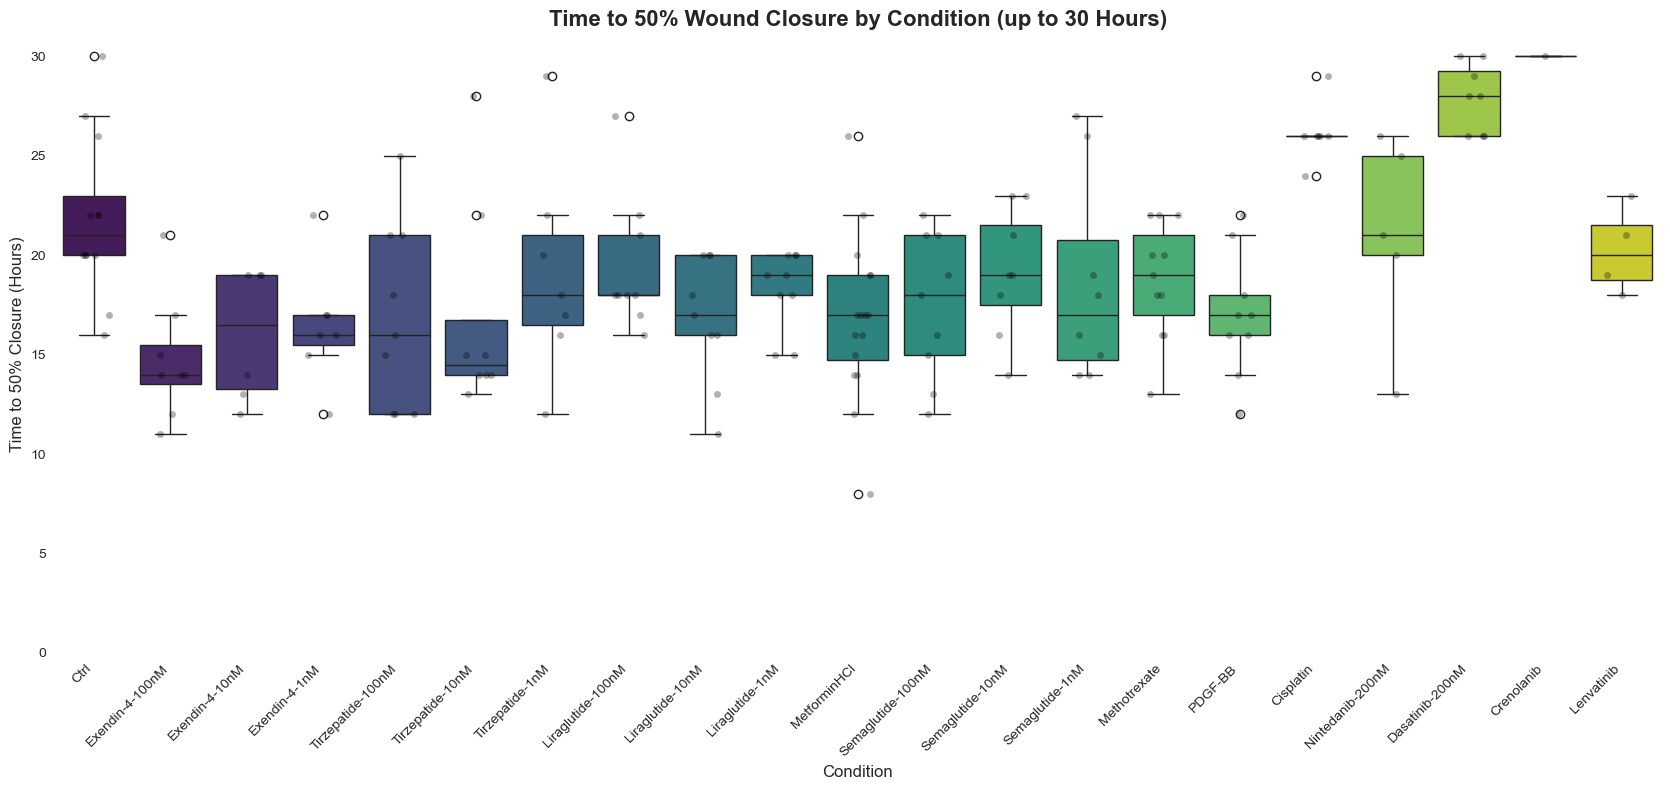


Summary of Time to 50% Closure (Hours):
                        mean  median       std  count
Condition_Name                                       
Ctrl               21.833333    21.0  4.063884     12
Exendin-4-100nM    14.750000    14.0  3.105295      8
Exendin-4-10nM     16.000000    16.5  3.346640      6
Exendin-4-1nM      16.428571    16.0  2.992053      7
Tirzepatide-100nM  16.888889    16.0  4.702245      9
Tirzepatide-10nM   16.875000    14.5  5.303301      8
Tirzepatide-1nM    19.142857    18.0  5.367450      7
Liraglutide-100nM  19.444444    18.0  3.395258      9
Liraglutide-10nM   16.777778    17.0  3.192874      9
Liraglutide-1nM    18.222222    19.0  1.986063      9
MetforminHCl       16.812500    17.0  4.102337     16
Semaglutide-100nM  17.444444    18.0  3.643869      9
Semaglutide-10nM   19.125000    19.0  3.181981      8
Semaglutide-1nM    18.625000    17.0  5.180665      8
Methotrexate       18.727273    19.0  2.901410     11
PDGF-BB            17.000000    17.0  3.1

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\2578940950.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df_time_to_50_closure.groupby('Condition_Name')['Time_to_50_Closure'].agg(['mean', 'median', 'std', 'count'])


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation # For statistical annotations

# Preamble: Assuming df_long needs to be prepared or is prepared with this logic.
# This ensures Condition_Name is parsed as expected by user_specified_condition_order.
# --- Start of df_long creation preamble (adapt if df_long is already available) ---
file_path = 'D:\\PythonProjects\\DataPlotting\\Data\\D34567.xlsx' # Example file path
df_excel = pd.read_excel(file_path, sheet_name='Normalized')
treatment_conditions = df_excel.columns[1:].tolist()
time_data = df_excel.iloc[:, 0]
wound_area_data = df_excel.iloc[:, 1:]
wound_area_df = pd.DataFrame(wound_area_data.values, columns=treatment_conditions, index=time_data)
wound_area_df.index.name = 'Time (Hours)'

def extract_condition_name(sample_name):
    # This function should correctly parse 'Well' names to 'Condition_Name'
    # e.g., 'Ctrl_A1' -> 'Ctrl', 'Exendin-4-100nM_B1' -> 'Exendin-4-100nM'
    full_match = re.match(r'([A-Za-z0-9\-]+(?:-[0-9\.]+nM)?)', sample_name)
    if full_match:
        return full_match.group(1)
    simple_match = re.match(r'([^_]+)', sample_name) # Fallback
    if simple_match:
        return simple_match.group(1)
    return sample_name

df_long = wound_area_df.reset_index().melt(
    id_vars=['Time (Hours)'],
    var_name='Well',
    value_name='Area'
)
df_long['Condition_Name'] = df_long['Well'].apply(extract_condition_name)
# --- End of Preamble for df_long creation ---

# Define the desired order of conditions
user_specified_condition_order = [
    'Ctrl', 'Exendin-4-100nM', 'Exendin-4-10nM', 'Exendin-4-1nM',
    'Tirzepatide-100nM', 'Tirzepatide-10nM', 'Tirzepatide-1nM',
    'Liraglutide-100nM', 'Liraglutide-10nM', 'Liraglutide-1nM',
    'MetforminHCl', 'Semaglutide-100nM', 'Semaglutide-10nM', 'Semaglutide-1nM',
    'Methotrexate', 'PDGF-BB', 'Cisplatin', 'Nintedanib-200nM',
    'Dasatinib-200nM', 'Crenolanib', 'Lenvatinib'
]

# Truncate data at 30 hours
df_long_truncated = df_long[df_long['Time (Hours)'] <= 30].copy()

# Determine the order of conditions for plotting based on user_specified_condition_order
# and availability in the truncated data
available_conditions_in_data = df_long_truncated['Condition_Name'].unique()
ordered_conditions_for_plot = [
    cond for cond in user_specified_condition_order if cond in available_conditions_in_data
]

if not ordered_conditions_for_plot:
    print("Warning: None of the specified conditions were found in the truncated data. Cannot generate plot.")
else:
    # Calculate time to 50% closure for each well
    time_to_50_closure_list = []
    for well in df_long_truncated['Well'].unique():
        well_data = df_long_truncated[df_long_truncated['Well'] == well].sort_values(by='Time (Hours)')
        condition_name = well_data['Condition_Name'].iloc[0]

        if condition_name not in ordered_conditions_for_plot: # Process only relevant conditions
            continue

        first_time_below_0_5 = well_data[well_data['Area'] <= 0.5]
        if not first_time_below_0_5.empty:
            time_val = first_time_below_0_5['Time (Hours)'].min()
            time_to_50_closure_list.append({
                'Well': well,
                'Condition_Name': condition_name,
                'Time_to_50_Closure': time_val
            })
        else:
            # If the well never reaches 0.5 area, we can choose to skip it or handle it differently
            # For this analysis, we will skip wells that do not reach 0.5 area within 30 hours
            continue
            # Uncomment the following lines if you want to include wells that never reach 0.5 area
            time_to_50_closure_list.append({
                 'Well': well,
                 'Condition_Name': condition_name,
                 'Time_to_50_Closure': 60  # Or some other value indicating no closure
            })
        # else:
            # Wells that don't reach 0.5 area within 30h are excluded from this analysis

    df_time_to_50_closure = pd.DataFrame(time_to_50_closure_list)

    if df_time_to_50_closure.empty:
        print("No wells reached 50% closure within 30 hours for the specified conditions.")
    else:
        # Ensure Condition_Name is categorical with the specified order for plotting
        df_time_to_50_closure['Condition_Name'] = pd.Categorical(
            df_time_to_50_closure['Condition_Name'],
            categories=ordered_conditions_for_plot,
            ordered=True
        )
        df_time_to_50_closure = df_time_to_50_closure.sort_values('Condition_Name')


        plt.figure(figsize=(max(12, len(ordered_conditions_for_plot) * 0.8), 8))
        ax = sns.boxplot(
            x='Condition_Name',
            y='Time_to_50_Closure',
            data=df_time_to_50_closure,
            order=ordered_conditions_for_plot, # Use the filtered and ordered list
            palette="viridis"
        )
        sns.stripplot(
            x='Condition_Name',
            y='Time_to_50_Closure',
            data=df_time_to_50_closure,
            order=ordered_conditions_for_plot,
            color='black',
            alpha=0.3,
            jitter=0.2,
            ax=ax
        )


        plt.title('Time to 50% Wound Closure by Condition (up to 30 Hours)', fontsize=16, fontweight='bold')
        plt.xlabel('Condition', fontsize=12)
        plt.ylabel('Time to 50% Closure (Hours)', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.ylim(bottom=0) # Time cannot be negative
        plt.grid(True, axis='y', linestyle=':', alpha=0.7)

        # Statistical comparisons to 'Ctrl'
        # Check if 'Ctrl' is in the data and in the ordered list
        ctrl_present_in_data = 'Ctrl' in df_time_to_50_closure['Condition_Name'].unique()
        ctrl_in_plot_order = 'Ctrl' in ordered_conditions_for_plot

        if ctrl_present_in_data and ctrl_in_plot_order:
            comparison_pairs = []
            # Only compare with conditions that have data and are in the plot
            conditions_in_plot_with_data = df_time_to_50_closure['Condition_Name'].unique().tolist()
            for cond in ordered_conditions_for_plot:
                if cond != 'Ctrl' and cond in conditions_in_plot_with_data:
                    comparison_pairs.append(('Ctrl', cond))

            if comparison_pairs:
                try:
                    add_stat_annotation(ax, data=df_time_to_50_closure, x='Condition_Name', y='Time_to_50_Closure',
                                        order=ordered_conditions_for_plot,
                                        box_pairs=comparison_pairs,
                                        test='Mann-Whitney', text_format='star', loc='inside', verbose=0,
                                        comparisons_correction=None) # No correction for multiple comparisons by default
                    print("\nStatistical comparisons (Mann-Whitney U test vs 'Ctrl') added to the plot.")
                    print("Significance levels: ns: p > 0.05, *: p <= 0.05, **: p <= 0.01, ***: p <= 0.001, ****: p <= 0.0001")
                except Exception as e:
                    print(f"Could not add statistical annotations: {e}")
                    print("This might be due to insufficient data for some comparisons or issues with statannot.")
            else:
                print("\nNo conditions eligible for comparison with 'Ctrl' or 'Ctrl' data insufficient.")
        else:
            print("\n'Ctrl' condition not found in the data reaching 50% closure or not in plot order, so no statistical comparisons were performed.")

        plt.tight_layout()
        plt.savefig('time_to_50_closure_boxplot_stats.png', dpi=300, bbox_inches='tight')
        plt.savefig('time_to_50_closure_boxplot_stats.svg', format='svg', bbox_inches='tight')
        plt.show()

        print("\nSummary of Time to 50% Closure (Hours):")
        summary_stats = df_time_to_50_closure.groupby('Condition_Name')['Time_to_50_Closure'].agg(['mean', 'median', 'std', 'count'])
        print(summary_stats)

        # List conditions that never reached 50% closure or were not in the specified list
        all_wells_in_truncated = set(df_long_truncated[df_long_truncated['Condition_Name'].isin(ordered_conditions_for_plot)]['Well'].unique())
        wells_reached_50_closure = set(df_time_to_50_closure['Well'].unique())
        wells_not_reached_50_closure = all_wells_in_truncated - wells_reached_50_closure

        if wells_not_reached_50_closure:
            print(f"\n{len(wells_not_reached_50_closure)} wells (from specified conditions) did not reach 50% closure within 30 hours:")
            # For brevity, you might list them or their conditions
            # conditions_not_reached = df_long_truncated[df_long_truncated['Well'].isin(wells_not_reached_50_closure)]['Condition_Name'].unique()
            # for cond_nr in conditions_not_reached:
            #     count_nr = len(df_long_truncated[(df_long_truncated['Well'].isin(wells_not_reached_50_closure)) & (df_long_truncated['Condition_Name'] == cond_nr)]['Well'].unique())
            #     print(f"- {cond_nr}: {count_nr} well(s)")


# Debugging information about conditions
if 'df_long_truncated' in locals(): # Check if df_long_truncated was defined
    all_data_conditions_from_df = set(df_long_truncated['Condition_Name'].unique())
    specified_conditions_set = set(user_specified_condition_order)

    missing_from_data = [cond for cond in user_specified_condition_order if cond not in all_data_conditions_from_df]
    if missing_from_data:
        print("\nThe following specified conditions were NOT found in the dataset (after truncating at 30h):")
        for cond in missing_from_data:
            print(f"- {cond}")

    not_in_spec_but_in_data = [cond for cond in all_data_conditions_from_df if cond not in specified_conditions_set]
    if not_in_spec_but_in_data and len(not_in_spec_but_in_data) < 20:
        print("\nFor reference, some conditions in your truncated data NOT in your specified list (max 20 shown):")
        for cond in not_in_spec_but_in_data[:20]:
            print(f"- {cond}")
    elif not_in_spec_but_in_data:
        print(f"\nFor reference, there are {len(not_in_spec_but_in_data)} conditions in your truncated data that were not in your specified list.")

In [9]:
# Determine the order of conditions for analysis based on user_specified_condition_order
# and availability in the truncated data
available_conditions_in_data = df_long_truncated['Condition_Name'].unique()
ordered_conditions_for_analysis = [
    cond for cond in user_specified_condition_order if cond in available_conditions_in_data
]

if not ordered_conditions_for_analysis:
    print("Warning: None of the specified conditions were found in the truncated data. Cannot perform analysis.")
else:
    # Filter data for the 24-hour time point
    df_24h = df_long_truncated[df_long_truncated['Time (Hours)'] == 24].copy()

    if df_24h.empty:
        print("No data available at the 24-hour time point.")
    else:
        # Filter for conditions specified in ordered_conditions_for_analysis
        df_24h_filtered_conditions = df_24h[df_24h['Condition_Name'].isin(ordered_conditions_for_analysis)]

        if df_24h_filtered_conditions.empty:
            print("No data available at 24 hours for the specified conditions.")
        else:
            # Count total wells per condition at 24h
            total_wells_at_24h = df_24h_filtered_conditions.groupby('Condition_Name')['Well'].nunique()

            # Identify wells with Area < 0.15 at 24h
            wells_below_threshold_at_24h = df_24h_filtered_conditions[df_24h_filtered_conditions['Area'] < 0.15]

            # Count wells below threshold per condition at 24h
            count_below_threshold_at_24h = wells_below_threshold_at_24h.groupby('Condition_Name')['Well'].nunique()

            # Combine counts into a DataFrame
            percentage_df = pd.DataFrame({
                'TotalWells_at_24h': total_wells_at_24h,
                'Wells_Area_lt_0.15_at_24h': count_below_threshold_at_24h
            }).fillna(0) # Fill NaN with 0 for conditions with no wells below threshold

            # Calculate percentage
            percentage_df['Percentage_Area_lt_0.15_at_24h'] = \
                (percentage_df['Wells_Area_lt_0.15_at_24h'] / percentage_df['TotalWells_at_24h'] * 100).fillna(0)

            # Reorder according to ordered_conditions_for_analysis and select only those conditions
            percentage_df = percentage_df.reindex(ordered_conditions_for_analysis).dropna(subset=['TotalWells_at_24h'])


            print("\nPercentage of tissues per condition with Area < 0.15 at 24 hours:")
            if not percentage_df.empty:
                for condition in ordered_conditions_for_analysis:
                    if condition in percentage_df.index:
                        row = percentage_df.loc[condition]
                        print(f"- {condition}: {row['Percentage_Area_lt_0.15_at_24h']:.2f}% "
                              f"({int(row['Wells_Area_lt_0.15_at_24h'])} of {int(row['TotalWells_at_24h'])} wells)")
                    else:
                        # This case handles conditions in ordered_conditions_for_analysis but not in df_24h
                        # (e.g. if a condition has no data at 24h at all)
                        # Check if the condition was in total_wells_at_24h to see if it had any wells at 24h
                        if condition in total_wells_at_24h.index and total_wells_at_24h.loc[condition] > 0:
                             print(f"- {condition}: 0.00% (0 of {int(total_wells_at_24h.loc[condition])} wells)")
                        # else:
                            # This condition was not even in the 24h data, so it's implicitly 0 out of 0.
                            # Or it was filtered out by dropna if TotalWells_at_24h was NaN (should not happen with fillna(0) earlier)
                            # print(f"- {condition}: No data at 24h")


            else:
                print("No conditions had data at 24 hours to calculate percentages.")

# Debugging information about conditions (can be kept or removed as needed)
if 'df_long_truncated' in locals():
    all_data_conditions_from_df = set(df_long_truncated['Condition_Name'].unique())
    specified_conditions_set = set(user_specified_condition_order)

    missing_from_data = [cond for cond in user_specified_condition_order if cond not in all_data_conditions_from_df]
    if missing_from_data:
        print("\nNote: The following specified conditions were NOT found in the dataset (truncated at 30h):")
        for cond in missing_from_data:
            print(f"- {cond}")


Percentage of tissues per condition with Area < 0.15 at 24 hours:
- Ctrl: 50.00% (6 of 12 wells)
- Exendin-4-100nM: 87.50% (7 of 8 wells)
- Exendin-4-10nM: 83.33% (5 of 6 wells)
- Exendin-4-1nM: 85.71% (6 of 7 wells)
- Tirzepatide-100nM: 77.78% (7 of 9 wells)
- Tirzepatide-10nM: 75.00% (6 of 8 wells)
- Tirzepatide-1nM: 42.86% (3 of 7 wells)
- Liraglutide-100nM: 66.67% (6 of 9 wells)
- Liraglutide-10nM: 88.89% (8 of 9 wells)
- Liraglutide-1nM: 77.78% (7 of 9 wells)
- MetforminHCl: 66.67% (12 of 18 wells)
- Semaglutide-100nM: 60.00% (6 of 10 wells)
- Semaglutide-10nM: 25.00% (2 of 8 wells)
- Semaglutide-1nM: 75.00% (6 of 8 wells)
- Methotrexate: 31.25% (5 of 16 wells)
- PDGF-BB: 100.00% (9 of 9 wells)
- Cisplatin: 0.00% (0 of 11 wells)
- Nintedanib-200nM: 28.57% (2 of 7 wells)
- Dasatinib-200nM: 0.00% (0 of 17 wells)
- Crenolanib: 0.00% (0 of 14 wells)
- Lenvatinib: 15.79% (3 of 19 wells)


C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3581329086.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


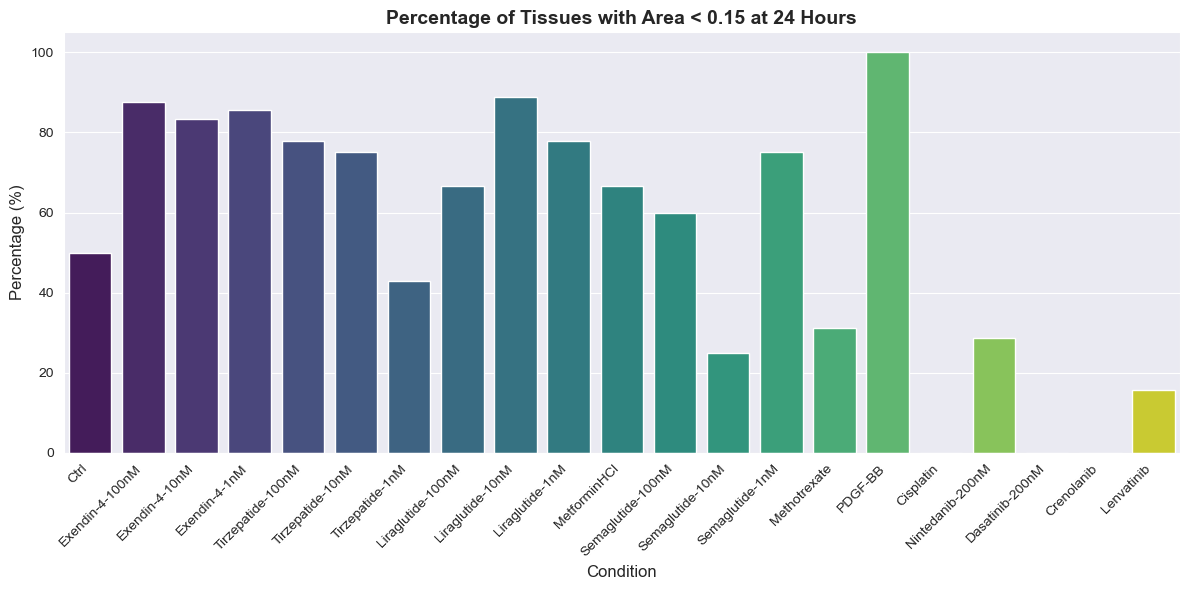

In [10]:
# Filter data for the 24-hour time point
df_24h = df_long_truncated[df_long_truncated['Time (Hours)'] == 24]

# Calculate the percentage of wells with area < 0.15 for each condition
total_wells_at_24h = df_24h.groupby('Condition_Name')['Well'].nunique()
wells_below_threshold_at_24h = df_24h[df_24h['Area'] < 0.15].groupby('Condition_Name')['Well'].nunique()
percentage_df = pd.DataFrame({
    'TotalWells_at_24h': total_wells_at_24h,
    'Wells_Area_lt_0.15_at_24h': wells_below_threshold_at_24h
}).fillna(0)
percentage_df['Percentage_Area_lt_0.15_at_24h'] = (
    percentage_df['Wells_Area_lt_0.15_at_24h'] / percentage_df['TotalWells_at_24h'] * 100
).fillna(0)

# Reorder according to user-specified condition order
percentage_df = percentage_df.reindex(user_specified_condition_order).dropna(subset=['TotalWells_at_24h'])

# Plot the percentages
plt.figure(figsize=(12, 6))
sns.barplot(
    x=percentage_df.index,
    y=percentage_df['Percentage_Area_lt_0.15_at_24h'],
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Tissues with Area < 0.15 at 24 Hours', fontsize=14, fontweight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.tight_layout()
plt.savefig('percentage_tissues_area_lt_0.15_24h.png', dpi=300)
plt.show()


Statistical Comparisons (Fisher's Exact Test vs 'Ctrl') for Percentage of Tissues with Area < 0.15 at 24h:
- Exendin-4-100nM vs Ctrl: p-value = 0.1577
- Exendin-4-10nM vs Ctrl: p-value = 0.6380
- Exendin-4-1nM vs Ctrl: p-value = 0.6332
- Tirzepatide-100nM vs Ctrl: p-value = 0.6605
- Tirzepatide-10nM vs Ctrl: p-value = 0.3729
- Tirzepatide-1nM vs Ctrl: p-value = 1.0000
- Liraglutide-100nM vs Ctrl: p-value = 0.6605
- Liraglutide-10nM vs Ctrl: p-value = 0.3666
- Liraglutide-1nM vs Ctrl: p-value = 0.3666
- MetforminHCl vs Ctrl: p-value = 0.4582
- Semaglutide-100nM vs Ctrl: p-value = 0.6914
- Semaglutide-10nM vs Ctrl: p-value = 0.3729
- Semaglutide-1nM vs Ctrl: p-value = 0.6699
- Methotrexate vs Ctrl: p-value = 0.4410
- PDGF-BB vs Ctrl: p-value = 0.0186
- Cisplatin vs Ctrl: p-value = 0.0137
- Nintedanib-200nM vs Ctrl: p-value = 0.6332
- Dasatinib-200nM vs Ctrl: p-value = 0.0019
- Crenolanib vs Ctrl: p-value = 0.0040
- Lenvatinib vs Ctrl: p-value = 0.0562


C:\Users\anish\AppData\Local\Temp\ipykernel_24472\1507009278.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


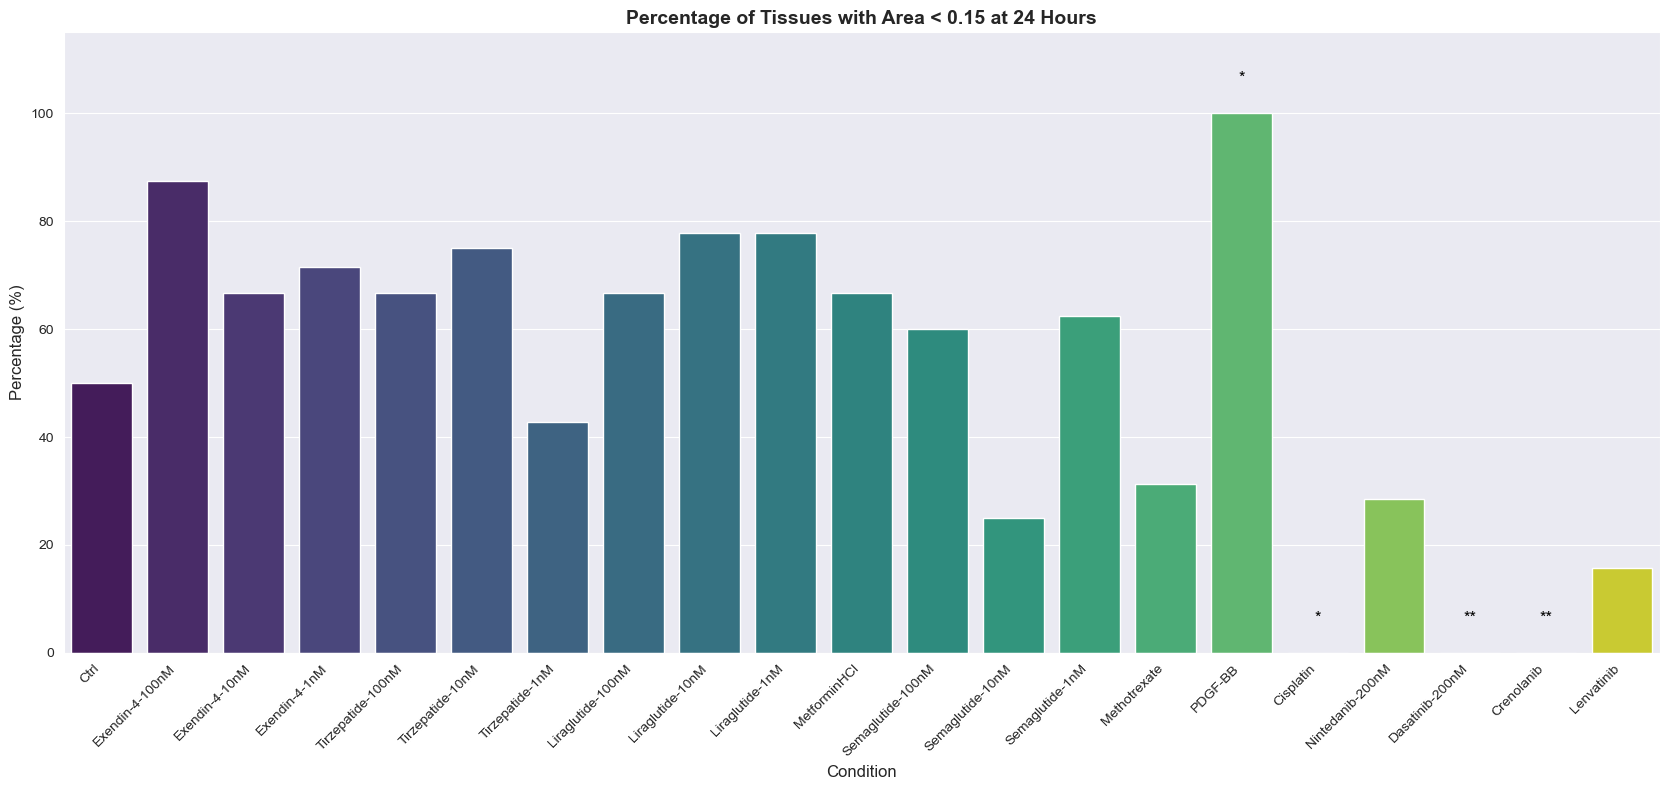

In [11]:
from scipy.stats import fisher_exact

percentage_summary_df = pd.DataFrame() # Initialize

if not ordered_conditions_for_analysis:
    print("Warning: None of the specified conditions were found in the truncated data. Cannot perform analysis or plotting.")
else:
    # Filter data for the 24-hour time point
    df_24h = df_long_truncated[df_long_truncated['Time (Hours)'] == 24].copy()

    if df_24h.empty:
        print("No data available at the 24-hour time point.")
    else:
        # Filter for conditions specified in ordered_conditions_for_analysis
        df_24h_filtered_conditions = df_24h[df_24h['Condition_Name'].isin(ordered_conditions_for_analysis)]

        if df_24h_filtered_conditions.empty:
            print("No data available at 24 hours for the specified conditions.")
        else:
            # Count total wells per condition at 24h
            total_wells_at_24h = df_24h_filtered_conditions.groupby('Condition_Name')['Well'].nunique()

            # Identify wells with Area < 0.15 at 24h
            wells_below_threshold_at_24h = df_24h_filtered_conditions[df_24h_filtered_conditions['Area'] < 0.10]

            # Count wells below threshold per condition at 24h
            count_below_threshold_at_24h = wells_below_threshold_at_24h.groupby('Condition_Name')['Well'].nunique()

            # Combine counts into a DataFrame
            percentage_summary_df = pd.DataFrame({
                'TotalWells_at_24h': total_wells_at_24h,
                'Wells_Area_lt_0.15_at_24h': count_below_threshold_at_24h
            }).fillna(0) # Fill NaN with 0 for conditions with no wells below threshold

            # Ensure counts are integers
            percentage_summary_df['TotalWells_at_24h'] = percentage_summary_df['TotalWells_at_24h'].astype(int)
            percentage_summary_df['Wells_Area_lt_0.15_at_24h'] = percentage_summary_df['Wells_Area_lt_0.15_at_24h'].astype(int)


            # Calculate percentage
            percentage_summary_df['Percentage_Area_lt_0.15_at_24h'] = \
                (percentage_summary_df['Wells_Area_lt_0.15_at_24h'] / percentage_summary_df['TotalWells_at_24h'] * 100).fillna(0)

            # Reorder according to ordered_conditions_for_analysis and select only those conditions
            percentage_summary_df = percentage_summary_df.reindex(ordered_conditions_for_analysis).dropna(subset=['TotalWells_at_24h'])

if percentage_summary_df.empty:
    print("No data to plot or analyze for percentages at 24h.")
else:
    # --- Statistical analysis using Fisher's Exact Test ---
    statistical_results_p_values = {}
    if 'Ctrl' in percentage_summary_df.index and percentage_summary_df.loc['Ctrl', 'TotalWells_at_24h'] > 0:
        ctrl_row = percentage_summary_df.loc['Ctrl']
        ctrl_below_threshold = ctrl_row['Wells_Area_lt_0.15_at_24h']
        ctrl_total_wells = ctrl_row['TotalWells_at_24h']
        ctrl_above_equal_threshold = ctrl_total_wells - ctrl_below_threshold

        for condition_name in percentage_summary_df.index:
            if condition_name != 'Ctrl':
                condition_row = percentage_summary_df.loc[condition_name]
                cond_below_threshold = condition_row['Wells_Area_lt_0.15_at_24h']
                cond_total_wells = condition_row['TotalWells_at_24h']

                if cond_total_wells == 0: # Skip if condition has no wells
                    statistical_results_p_values[condition_name] = np.nan
                    continue

                cond_above_equal_threshold = cond_total_wells - cond_below_threshold

                # Create the 2x2 contingency table
                table = [
                    [cond_below_threshold, cond_above_equal_threshold],
                    [ctrl_below_threshold, ctrl_above_equal_threshold]
                ]

                odds_ratio, p_value = fisher_exact(table)
                statistical_results_p_values[condition_name] = p_value

        print("\nStatistical Comparisons (Fisher's Exact Test vs 'Ctrl') for Percentage of Tissues with Area < 0.15 at 24h:")
        if statistical_results_p_values:
            for condition, p_value in statistical_results_p_values.items():
                if pd.notna(p_value):
                    print(f"- {condition} vs Ctrl: p-value = {p_value:.4f}")
                else:
                    print(f"- {condition} vs Ctrl: Not enough data for comparison")
        else:
            print("No other conditions to compare with 'Ctrl'.")

    elif 'Ctrl' not in percentage_summary_df.index:
        print("\n'Ctrl' condition not found in the 24-hour data for percentage calculation. Cannot perform statistical comparisons against 'Ctrl'.")
    elif percentage_summary_df.loc['Ctrl', 'TotalWells_at_24h'] == 0:
            print("\n'Ctrl' condition has no wells at 24 hours. Cannot perform statistical comparisons against 'Ctrl'.")

    # --- Plotting code ---
    plt.figure(figsize=(max(10, len(percentage_summary_df.index) * 0.8), 8)) # Adjusted figure size for annotations
    ax = sns.barplot(
        x=percentage_summary_df.index,
        y='Percentage_Area_lt_0.15_at_24h',
        data=percentage_summary_df,
        palette='viridis'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Percentage of Tissues with Area < 0.15 at 24 Hours', fontsize=14, fontweight='bold')
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)

    # Add significance markers
    def p_value_to_asterisks(p_val):
        if p_val < 0.0001:
            return "****"
        elif p_val < 0.001:
            return "***"
        elif p_val < 0.01:
            return "**"
        elif p_val < 0.05:
            return "*"
        return "" # No asterisk if not significant or NaN

    y_max = percentage_summary_df['Percentage_Area_lt_0.15_at_24h'].max()
    annotation_offset = y_max * 0.05 # 5% of max bar height as offset

    for i, condition_name in enumerate(percentage_summary_df.index):
        if condition_name != 'Ctrl' and condition_name in statistical_results_p_values:
            p_val = statistical_results_p_values[condition_name]
            if pd.notna(p_val):
                asterisks = p_value_to_asterisks(p_val)
                if asterisks:
                    bar_height = percentage_summary_df.loc[condition_name, 'Percentage_Area_lt_0.15_at_24h']
                    ax.text(i, bar_height + annotation_offset, asterisks,
                            ha='center', va='bottom', color='black', fontsize=12)

    plt.ylim(top=y_max + y_max * 0.15) # Adjust y-limit to make space for annotations
    plt.tight_layout()
    plt.savefig('sw_percentage_tissues_area_lt_0.15_24h_with_stats_markers.png', dpi=300)
    plt.show()

# Debugging information about conditions
if 'df_long_truncated' in locals():
    all_data_conditions_from_df = set(df_long_truncated['Condition_Name'].unique())
    specified_conditions_set = set(user_specified_condition_order)

    missing_from_data = [cond for cond in user_specified_condition_order if cond not in all_data_conditions_from_df]
    if missing_from_data:
        print("\nNote: The following specified conditions were NOT found in the dataset (truncated at 30h):")
        for cond in missing_from_data:
            print(f"- {cond}")

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\2601437489.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


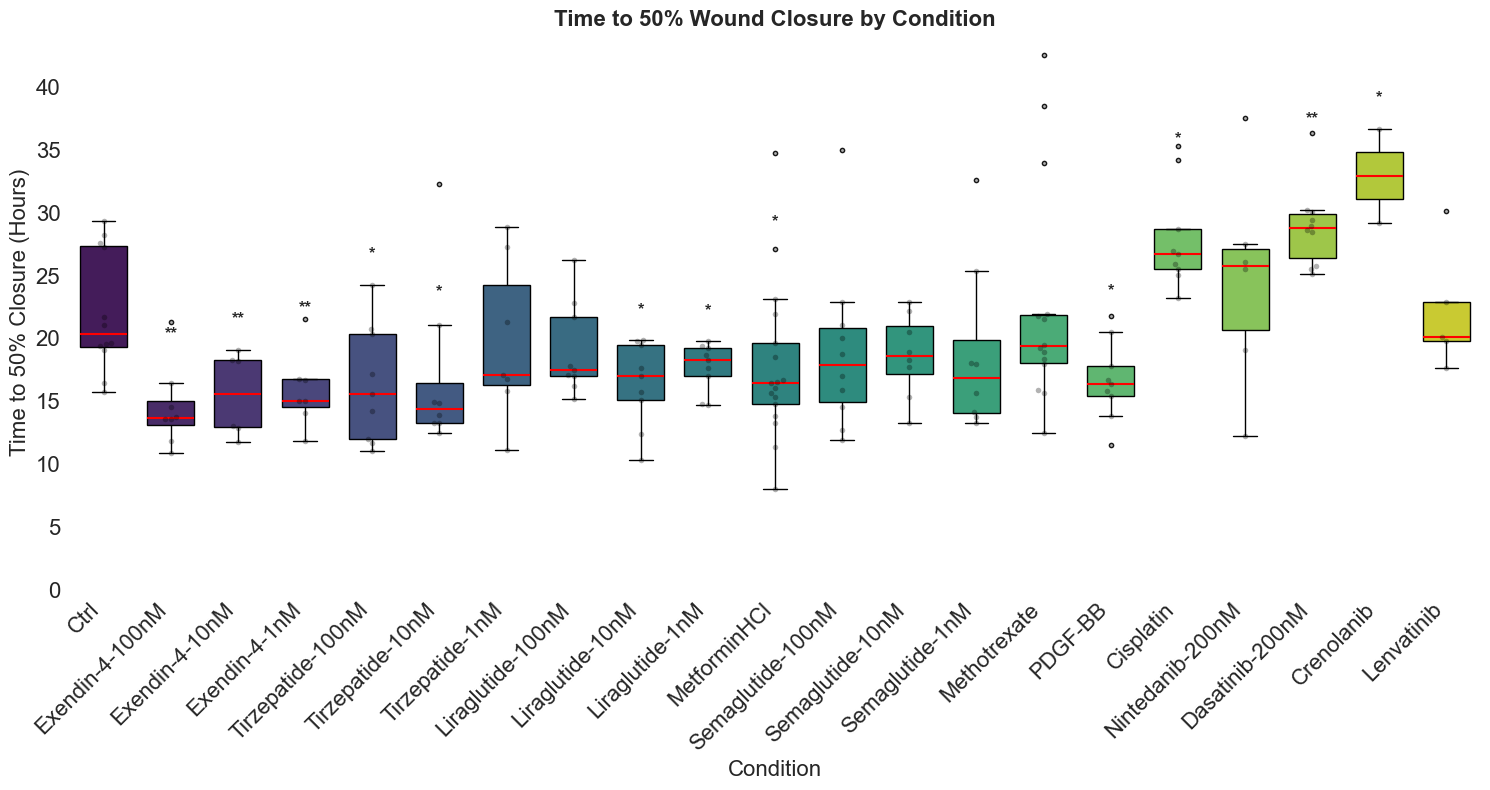


Summary of Time to 50% Wound Closure (hours):
       Condition_Name       Mean     Median    StdDev  Count  Total_Wells  \
2                Ctrl  22.085761  20.358014  4.766773     12           12   
5     Exendin-4-100nM  14.489995  13.673999  3.224044      8            8   
6      Exendin-4-10nM  15.545468  15.613099  3.305183      6            6   
7       Exendin-4-1nM  15.854987  15.034072  3.029577      7            7   
19  Tirzepatide-100nM  16.326771  15.553164  4.667245      9            9   
20   Tirzepatide-10nM  17.008452  14.383808  6.722422      8            8   
21    Tirzepatide-1nM  19.740988  17.075297  6.425132      7            7   
9   Liraglutide-100nM  19.066596  17.506132  3.671055      9            9   
10   Liraglutide-10nM  16.364212  16.977980  3.345778      9            9   
11    Liraglutide-1nM  17.716555  18.278409  1.906076      9            9   
12       MetforminHCl  17.831541  16.423545  6.256414     17           18   
16  Semaglutide-100nM  18.994

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\2601437489.py:202: FutureWarning: The provided callable <function nanmean at 0x000001FC149AE8E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_stats = closure_df.groupby('Condition_Name')['Time_to_50pct_Closure'].agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\2601437489.py:202: FutureWarning: The provided callable <function nanmedian at 0x000001FC149AEC00> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_stats = closure_df.groupby('Condition_Name')['Time_to_50pct_Closure'].agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\2601437489.py:202: FutureWarning: The provided callable <function nanstd at 0x000001FC149AF2E0> is currently using SeriesGroupBy.std. In

In [12]:
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- Calculate time to 50% wound closure for each well ---
def calculate_time_to_closure(well_data, threshold=0.5):
    """
    Calculate the time point at which the wound area drops below the threshold.
    Returns np.nan if the threshold is never reached.
    """
    # Sort data by time
    well_data = well_data.sort_values('Time (Hours)')

    # Check if area ever gets below threshold
    if not any(well_data['Area'] <= threshold):
        return np.nan

    # Find first time point where area is below threshold
    first_below = well_data[well_data['Area'] <= threshold].iloc[0]

    # If the first time point is already below threshold, return that time
    if well_data.iloc[0]['Area'] <= threshold:
        return first_below['Time (Hours)']

    # Find the time point just before dropping below threshold
    last_above_idx = well_data[well_data['Area'] > threshold].index.max()
    last_above = well_data.loc[last_above_idx]

    # Linear interpolation between the two points
    time_before = last_above['Time (Hours)']
    area_before = last_above['Area']
    time_after = first_below['Time (Hours)']
    area_after = first_below['Area']

    # Avoid division by zero
    if area_before == area_after:
        return time_before

    # Interpolate
    fraction = (threshold - area_before) / (area_after - area_before)
    interpolated_time = time_before + fraction * (time_after - time_before)

    return interpolated_time

# Create list to store time to 50% closure for each well
closure_times = []

for well_name in df_long['Well'].unique():
    well_data = df_long[df_long['Well'] == well_name]
    condition = well_data['Condition_Name'].iloc[0]
    time_to_closure = calculate_time_to_closure(well_data)
    closure_times.append({
        'Well': well_name,
        'Condition_Name': condition,
        'Time_to_50pct_Closure': time_to_closure
    })

# Convert to DataFrame
closure_df = pd.DataFrame(closure_times)

# Get available conditions in order specified by user
available_conditions = set(closure_df['Condition_Name'].unique())
ordered_conditions = [c for c in user_specified_condition_order if c in available_conditions]

# --- Perform statistical tests against Ctrl ---
p_values = {}
if 'Ctrl' in available_conditions:
    ctrl_data = closure_df[closure_df['Condition_Name'] == 'Ctrl']['Time_to_50pct_Closure'].dropna()

    for condition in ordered_conditions:
        if condition != 'Ctrl':
            cond_data = closure_df[closure_df['Condition_Name'] == condition]['Time_to_50pct_Closure'].dropna()
            if len(cond_data) > 0:
                # Use Mann-Whitney U test as non-parametric alternative to t-test
                try:
                    stat, p = mannwhitneyu(cond_data, ctrl_data)
                    p_values[condition] = p
                except ValueError:  # In case of no overlap
                    p_values[condition] = np.nan
            else:
                p_values[condition] = np.nan
else:
    print("Warning: 'Ctrl' condition not found in the dataset")

# --- Create the box and whisker plot with white background ---
plt.figure(figsize=(15, 8))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Filter data for ordered conditions
plot_data = closure_df[closure_df['Condition_Name'].isin(ordered_conditions)].copy()
plot_data['Condition_Name'] = pd.Categorical(plot_data['Condition_Name'],
                                            categories=ordered_conditions,
                                            ordered=True)

# Create box plot
ax = sns.boxplot(
    x='Condition_Name',
    y='Time_to_50pct_Closure',
    data=plot_data,
    palette='viridis',
    width=0.7,
    fliersize=3,
    linewidth=1,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    medianprops=dict(color='red', linewidth=1.5),
    capprops=dict(color='black'),
    showfliers=True
)

# Add individual data points with swarmplot
sns.swarmplot(
    x='Condition_Name',
    y='Time_to_50pct_Closure',
    data=plot_data,
    color='black',
    size=4,
    alpha=0.3,
    dodge=True
)

# Add significance markers - modified to only show significant p-values
def p_value_to_asterisks(p_val):
    if pd.isna(p_val):
        return ""
    if p_val < 0.0001:
        return "****"
    elif p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    return ""  # Return empty string instead of "ns" for non-significant values

# Get y-coordinate limits for annotations
whisker_tops = []
for i, condition in enumerate(ordered_conditions):
    condition_data = plot_data[plot_data['Condition_Name'] == condition]['Time_to_50pct_Closure'].dropna()
    if len(condition_data) > 0:
        q3 = np.percentile(condition_data, 75)
        iqr = np.percentile(condition_data, 75) - np.percentile(condition_data, 25)
        upper_whisker = min(np.max(condition_data), q3 + 1.5 * iqr)
        whisker_tops.append(upper_whisker)
    else:
        whisker_tops.append(0)

# Find the maximum height for positioning annotations
y_max = max(whisker_tops)
y_offset = y_max * 0.05  # 5% of max for spacing

# Add significance markers above whiskers (only for significant conditions)
for i, condition in enumerate(ordered_conditions):
    if condition != 'Ctrl' and condition in p_values:
        p_val = p_values[condition]
        marker = p_value_to_asterisks(p_val)
        if marker:  # Only add if there's a significant marker to show
            y_pos = whisker_tops[i] + y_offset
            plt.text(i, y_pos, marker, ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add a legend for significance
handles = [
    mpatches.Patch(color='none', label='* p < 0.05'),
    mpatches.Patch(color='none', label='** p < 0.01'),
    mpatches.Patch(color='none', label='*** p < 0.001'),
    mpatches.Patch(color='none', label='**** p < 0.0001')
]
#plt.legend(handles=handles, loc='upper right', frameon=False)

# Format the plot
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.title('Time to 50% Wound Closure by Condition', fontsize=16, fontweight='bold')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Time to 50% Closure (Hours)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.yticks(fontsize=16)
# Add some buffer space at the top for annotations
plt.ylim(0, y_max * 1.2)
plt.tight_layout()

# Add x and y axes lines
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Save and show the plot
plt.savefig('time_to_50pct_wound_closure_boxplot.png', dpi=300, bbox_inches='tight')
plt.savefig('time_to_50pct_wound_closure_boxplot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary of Time to 50% Wound Closure (hours):")
summary_stats = closure_df.groupby('Condition_Name')['Time_to_50pct_Closure'].agg(
    Mean=np.nanmean,
    Median=np.nanmedian,
    StdDev=np.nanstd,
    Count=lambda x: np.sum(~np.isnan(x)),
    Total_Wells=lambda x: len(x)
).reset_index()
summary_stats['% Wells Reaching 50%'] = (summary_stats['Count'] / summary_stats['Total_Wells'] * 100).round(1)

# Order and print summary statistics
ordered_summary = summary_stats[summary_stats['Condition_Name'].isin(ordered_conditions)].copy()
ordered_summary['Condition_Name'] = pd.Categorical(
    ordered_summary['Condition_Name'],
    categories=ordered_conditions,
    ordered=True
)
ordered_summary = ordered_summary.sort_values('Condition_Name')
print(ordered_summary[['Condition_Name', 'Mean', 'Median', 'StdDev', 'Count', 'Total_Wells', '% Wells Reaching 50%']])

# Print statistical comparison results
if p_values:
    print("\nStatistical Comparisons (Mann-Whitney U Test vs 'Ctrl'):")
    for condition, p_val in sorted(p_values.items(), key=lambda x: ordered_conditions.index(x[0]) if x[0] in ordered_conditions else float('inf')):
        asterisks = p_value_to_asterisks(p_val)
        significance = f" {asterisks}" if asterisks else " (not significant)"
        print(f"- {condition} vs Ctrl: p = {p_val:.4f}{significance}")

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3260693261.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


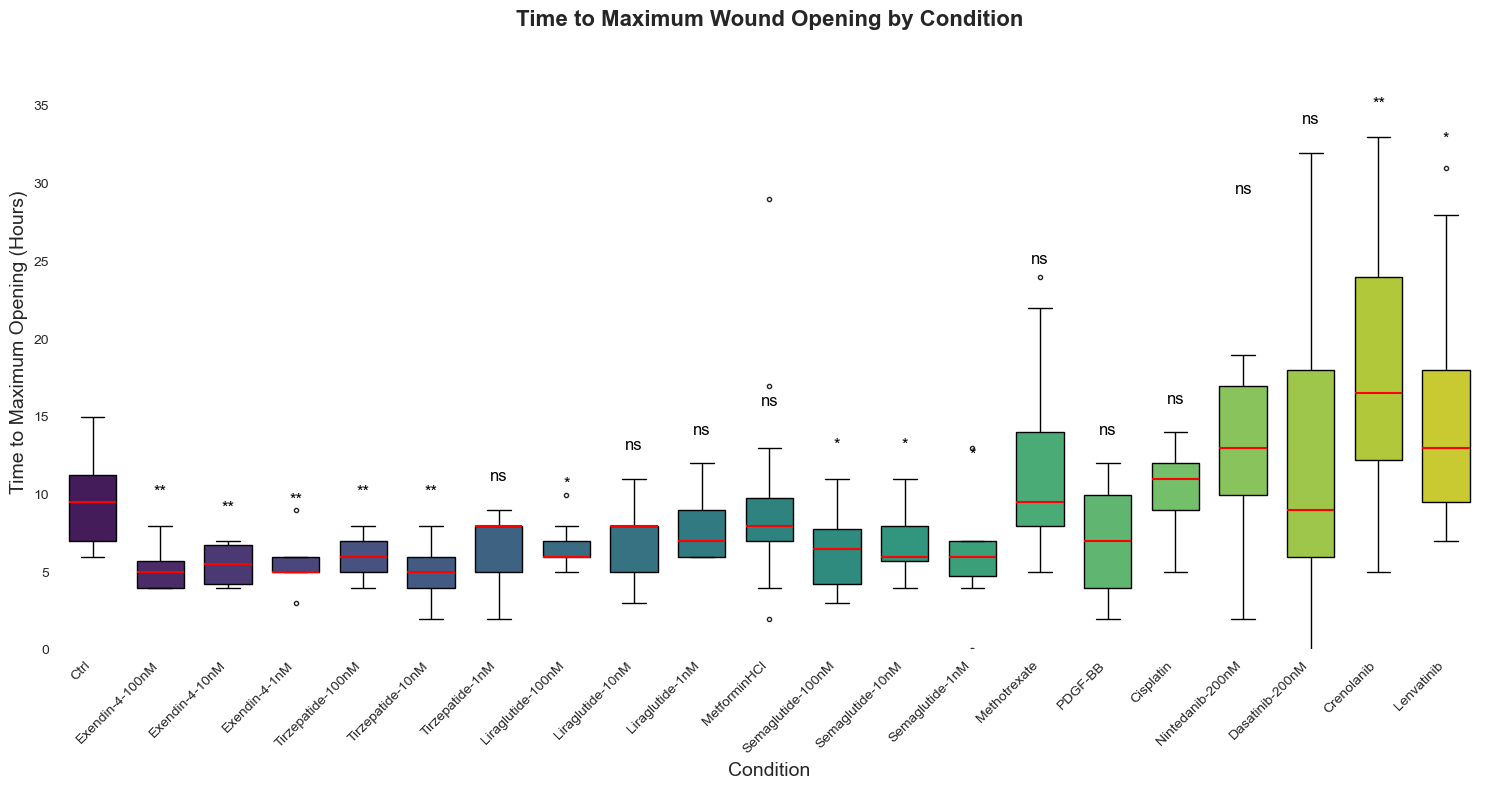


Summary of Time to Maximum Wound Opening (hours):
       Condition_Name  Mean_Time  Median_Time  StdDev_Time  Mean_Max_Area  \
2                Ctrl   9.583333          9.5     2.968267       1.918169   
5     Exendin-4-100nM   5.375000          5.0     1.685018       1.581977   
6      Exendin-4-10nM   5.500000          5.5     1.378405       1.654412   
7       Exendin-4-1nM   5.571429          5.0     1.812654       1.529620   
19  Tirzepatide-100nM   5.777778          6.0     1.394433       1.844313   
20   Tirzepatide-10nM   5.000000          5.0     1.772811       1.645775   
21    Tirzepatide-1nM   6.428571          8.0     2.507133       1.810968   
9   Liraglutide-100nM   6.666667          6.0     1.581139       1.820109   
10   Liraglutide-10nM   7.000000          8.0     2.549510       1.789252   
11    Liraglutide-1nM   7.666667          7.0     2.061553       1.862737   
12       MetforminHCl   9.222222          8.0     5.995641       1.611138   
16  Semaglutide-100nM   6

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3260693261.py:171: FutureWarning: The provided callable <function mean at 0x000001FC14859440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_stats = max_opening_df.groupby('Condition_Name').agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3260693261.py:171: FutureWarning: The provided callable <function median at 0x000001FC149A72E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_stats = max_opening_df.groupby('Condition_Name').agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3260693261.py:171: FutureWarning: The provided callable <function std at 0x000001FC14859580> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable 

In [13]:

from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches



# Drop specified conditions
conditions_to_drop = [
    'IbuprofenLysine-10uM',
    'Diclofenac-10uM',
    'Nintedanib-10nM'
]
df_long = df_long[~df_long['Condition_Name'].isin(conditions_to_drop)]



# --- Calculate time to maximum opening for each well ---
def calculate_time_to_max_opening(well_data):
    """
    Calculate the time point at which the wound area reaches its maximum value.
    """
    # Sort data by time
    well_data = well_data.sort_values('Time (Hours)')

    # Find the time point with the maximum wound area
    max_area_idx = well_data['Area'].idxmax()
    time_at_max = well_data.loc[max_area_idx]['Time (Hours)']
    max_area = well_data.loc[max_area_idx]['Area']

    return time_at_max, max_area

# Create list to store time to maximum opening for each well
max_opening_times = []

for well_name in df_long['Well'].unique():
    well_data = df_long[df_long['Well'] == well_name]
    condition = well_data['Condition_Name'].iloc[0]
    time_to_max, max_area = calculate_time_to_max_opening(well_data)
    max_opening_times.append({
        'Well': well_name,
        'Condition_Name': condition,
        'Time_to_Max_Opening': time_to_max,
        'Max_Area': max_area
    })

# Convert to DataFrame
max_opening_df = pd.DataFrame(max_opening_times)

# Get available conditions in order specified by user
available_conditions = set(max_opening_df['Condition_Name'].unique())
ordered_conditions = [c for c in user_specified_condition_order if c in available_conditions]

# --- Perform statistical tests against Ctrl ---
p_values = {}
if 'Ctrl' in available_conditions:
    ctrl_data = max_opening_df[max_opening_df['Condition_Name'] == 'Ctrl']['Time_to_Max_Opening'].dropna()

    for condition in ordered_conditions:
        if condition != 'Ctrl':
            condition_data = max_opening_df[max_opening_df['Condition_Name'] == condition]['Time_to_Max_Opening'].dropna()

            if len(condition_data) > 0 and len(ctrl_data) > 0:
                stat, p_val = mannwhitneyu(condition_data, ctrl_data, alternative='two-sided')
                p_values[condition] = p_val
            else:
                p_values[condition] = np.nan
else:
    print("Warning: 'Ctrl' condition not found in the dataset")

# --- Create the box and whisker plot with white background and axes ---
plt.figure(figsize=(15, 8))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Filter data for ordered conditions
plot_data = max_opening_df[max_opening_df['Condition_Name'].isin(ordered_conditions)].copy()
plot_data['Condition_Name'] = pd.Categorical(plot_data['Condition_Name'],
                                           categories=ordered_conditions,
                                           ordered=True)

# Create box plot
ax = sns.boxplot(
    x='Condition_Name',
    y='Time_to_Max_Opening',
    data=plot_data,
    palette='viridis',
    width=0.7,
    fliersize=3,
    linewidth=1,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    medianprops=dict(color='red', linewidth=1.5),
    capprops=dict(color='black'),
    showfliers=True
)

# Add significance markers
def p_value_to_asterisks(p_val):
    if pd.isna(p_val):
        return ""
    if p_val < 0.0001:
        return "****"
    elif p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    return "ns"

# Get y-coordinate limits for annotations
whisker_tops = []
for i, condition in enumerate(ordered_conditions):
    condition_data = plot_data[plot_data['Condition_Name'] == condition]['Time_to_Max_Opening'].dropna()
    if len(condition_data) > 0:
        q3 = np.percentile(condition_data, 75)
        iqr = np.percentile(condition_data, 75) - np.percentile(condition_data, 25)
        upper_whisker = min(np.max(condition_data), q3 + 1.5 * iqr)
        whisker_tops.append(upper_whisker)
    else:
        whisker_tops.append(0)

# Find the maximum height for positioning annotations
y_max = max(whisker_tops) if whisker_tops else 0
y_offset = y_max * 0.05  # 5% of max for spacing

# Add significance markers above whiskers (only for significant conditions)
for i, condition in enumerate(ordered_conditions):
    if condition != 'Ctrl' and condition in p_values:
        p_val = p_values[condition]
        marker = p_value_to_asterisks(p_val)
        if marker:  # Only add if there's a significant marker to show
            plt.text(i, whisker_tops[i] + y_offset, marker,
                     ha='center', va='bottom', color='black', fontsize=12)


# Add a legend for significance
handles = [
    mpatches.Patch(color='none', label='* p < 0.05'),
    mpatches.Patch(color='none', label='** p < 0.01'),
    mpatches.Patch(color='none', label='*** p < 0.001'),
    mpatches.Patch(color='none', label='**** p < 0.0001')
]
# plt.legend(handles=handles, loc='upper right', frameon=False)

# Format the plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Time to Maximum Wound Opening by Condition', fontsize=16, fontweight='bold')
plt.xlabel('Condition', fontsize=14)
plt.ylabel('Time to Maximum Opening (Hours)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add x and y axes lines
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(1.5)  # Make x-axis line thicker
ax.spines['left'].set_linewidth(1.5)    # Make y-axis line thicker
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add some buffer space at the top for annotations
plt.ylim(0, y_max * 1.2)
plt.tight_layout()

# Save and show the plot
plt.savefig('time_to_max_wound_opening_boxplot.png', dpi=300, bbox_inches='tight')
plt.savefig('time_to_max_wound_opening_boxplot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary of Time to Maximum Wound Opening (hours):")
summary_stats = max_opening_df.groupby('Condition_Name').agg(
    Mean_Time=('Time_to_Max_Opening', np.mean),
    Median_Time=('Time_to_Max_Opening', np.median),
    StdDev_Time=('Time_to_Max_Opening', np.std),
    Mean_Max_Area=('Max_Area', np.mean),
    Count=('Time_to_Max_Opening', 'count')
).reset_index()

# Order and print summary statistics
ordered_summary = summary_stats[summary_stats['Condition_Name'].isin(ordered_conditions)].copy()
ordered_summary['Condition_Name'] = pd.Categorical(
    ordered_summary['Condition_Name'],
    categories=ordered_conditions,
    ordered=True
)
ordered_summary = ordered_summary.sort_values('Condition_Name')
print(ordered_summary[['Condition_Name', 'Mean_Time', 'Median_Time', 'StdDev_Time', 'Mean_Max_Area', 'Count']])

# Print statistical comparison results
if p_values:
    print("\nStatistical Comparisons (Mann-Whitney U Test vs 'Ctrl'):")
    for condition, p_val in sorted(p_values.items(), key=lambda x: ordered_conditions.index(x[0]) if x[0] in ordered_conditions else float('inf')):
        stars = p_value_to_asterisks(p_val)
        print(f"- {condition} vs Ctrl: p = {p_val:.4f} {stars}")

# Report conditions that were explicitly dropped
print("\nThe following conditions were explicitly dropped from the analysis:")
for cond in conditions_to_drop:
    print(f"- {cond}")

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3017674736.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


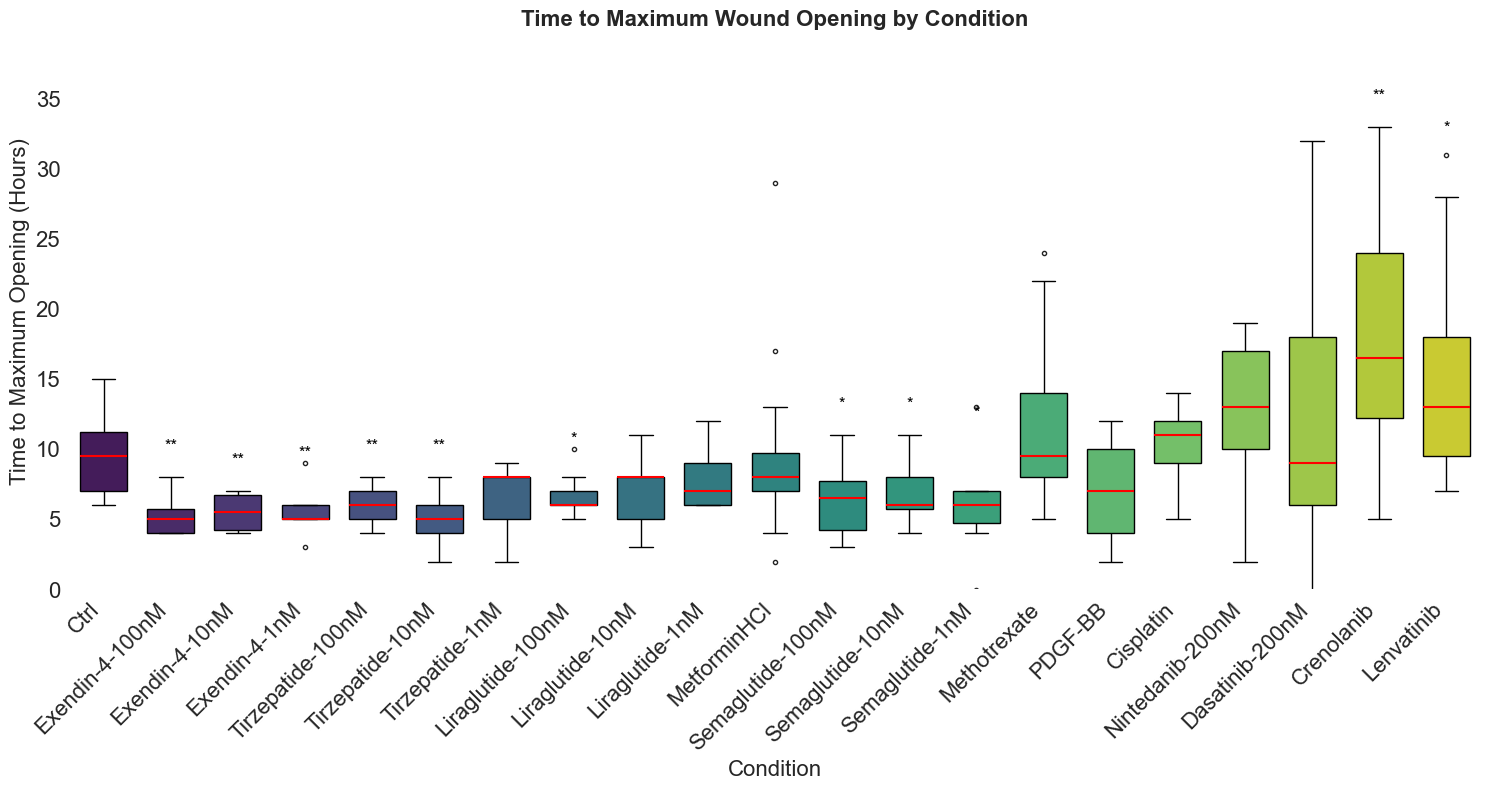


Summary of Time to Maximum Wound Opening (hours):
       Condition_Name  Mean_Time  Median_Time  StdDev_Time  Mean_Max_Area  \
2                Ctrl   9.583333          9.5     2.968267       1.918169   
5     Exendin-4-100nM   5.375000          5.0     1.685018       1.581977   
6      Exendin-4-10nM   5.500000          5.5     1.378405       1.654412   
7       Exendin-4-1nM   5.571429          5.0     1.812654       1.529620   
19  Tirzepatide-100nM   5.777778          6.0     1.394433       1.844313   
20   Tirzepatide-10nM   5.000000          5.0     1.772811       1.645775   
21    Tirzepatide-1nM   6.428571          8.0     2.507133       1.810968   
9   Liraglutide-100nM   6.666667          6.0     1.581139       1.820109   
10   Liraglutide-10nM   7.000000          8.0     2.549510       1.789252   
11    Liraglutide-1nM   7.666667          7.0     2.061553       1.862737   
12       MetforminHCl   9.222222          8.0     5.995641       1.611138   
16  Semaglutide-100nM   6

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3017674736.py:96: FutureWarning: The provided callable <function mean at 0x000001FC14859440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_stats = max_opening_df.groupby('Condition_Name').agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3017674736.py:96: FutureWarning: The provided callable <function median at 0x000001FC149A72E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_stats = max_opening_df.groupby('Condition_Name').agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3017674736.py:96: FutureWarning: The provided callable <function std at 0x000001FC14859580> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable wil

In [14]:


# --- Create the box and whisker plot with white background and axes ---
plt.figure(figsize=(15, 8))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Filter data for ordered conditions
plot_data = max_opening_df[max_opening_df['Condition_Name'].isin(ordered_conditions)].copy()
plot_data['Condition_Name'] = pd.Categorical(plot_data['Condition_Name'],
                                           categories=ordered_conditions,
                                           ordered=True)

# Create box plot
ax = sns.boxplot(
    x='Condition_Name',
    y='Time_to_Max_Opening',
    data=plot_data,
    palette='viridis',
    width=0.7,
    fliersize=3,
    linewidth=1,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    medianprops=dict(color='red', linewidth=1.5),
    capprops=dict(color='black'),
    showfliers=True
)

# Add only significant markers (no "ns")
def p_value_to_asterisks(p_val):
    if pd.isna(p_val):
        return ""
    if p_val < 0.0001:
        return "****"
    elif p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    return ""  # Return empty string instead of "ns" for non-significant values

# Get y-coordinate limits for annotations
whisker_tops = []
for i, condition in enumerate(ordered_conditions):
    condition_data = plot_data[plot_data['Condition_Name'] == condition]['Time_to_Max_Opening'].dropna()
    if len(condition_data) > 0:
        q3 = np.percentile(condition_data, 75)
        iqr = np.percentile(condition_data, 75) - np.percentile(condition_data, 25)
        upper_whisker = min(np.max(condition_data), q3 + 1.5 * iqr)
        whisker_tops.append(upper_whisker)
    else:
        whisker_tops.append(0)

# Find the maximum height for positioning annotations
y_max = max(whisker_tops) if whisker_tops else 0
y_offset = y_max * 0.05  # 5% of max for spacing

# Add significance markers above whiskers (only for significant conditions)
for i, condition in enumerate(ordered_conditions):
    if condition != 'Ctrl' and condition in p_values:
        p_val = p_values[condition]
        marker = p_value_to_asterisks(p_val)
        if marker:  # Only add if there's a significant marker to show
            plt.text(i, whisker_tops[i] + y_offset, marker,
                     ha='center', va='bottom', color='black', fontsize=12)



# Format the plot
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.title('Time to Maximum Wound Opening by Condition', fontsize=16, fontweight='bold')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Time to Maximum Opening (Hours)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.yticks(fontsize=16)

# Add x and y axes lines
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(1.5)  # Make x-axis line thicker
ax.spines['left'].set_linewidth(1.5)    # Make y-axis line thicker
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add some buffer space at the top for annotations
plt.ylim(0, y_max * 1.2)
plt.tight_layout()

# Save and show the plot
plt.savefig('time_to_max_wound_opening_boxplot.png', dpi=300, bbox_inches='tight')
plt.savefig('time_to_max_wound_opening_boxplot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary of Time to Maximum Wound Opening (hours):")
summary_stats = max_opening_df.groupby('Condition_Name').agg(
    Mean_Time=('Time_to_Max_Opening', np.mean),
    Median_Time=('Time_to_Max_Opening', np.median),
    StdDev_Time=('Time_to_Max_Opening', np.std),
    Mean_Max_Area=('Max_Area', np.mean),
    Count=('Time_to_Max_Opening', 'count')
).reset_index()

# Order and print summary statistics
ordered_summary = summary_stats[summary_stats['Condition_Name'].isin(ordered_conditions)].copy()
ordered_summary['Condition_Name'] = pd.Categorical(
    ordered_summary['Condition_Name'],
    categories=ordered_conditions,
    ordered=True
)
ordered_summary = ordered_summary.sort_values('Condition_Name')
print(ordered_summary[['Condition_Name', 'Mean_Time', 'Median_Time', 'StdDev_Time', 'Mean_Max_Area', 'Count']])

# Print statistical comparison results
if p_values:
    print("\nStatistical Comparisons (Mann-Whitney U Test vs 'Ctrl'):")
    for condition, p_val in sorted(p_values.items(), key=lambda x: ordered_conditions.index(x[0]) if x[0] in ordered_conditions else float('inf')):
        asterisks = p_value_to_asterisks(p_val)
        significance = f" {asterisks}" if asterisks else " (not significant)"
        print(f"- {condition} vs Ctrl: p = {p_val:.4f}{significance}")

# Report conditions that were explicitly dropped
print("\nThe following conditions were explicitly dropped from the analysis:")
for cond in conditions_to_drop:
    print(f"- {cond}")

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3130950576.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


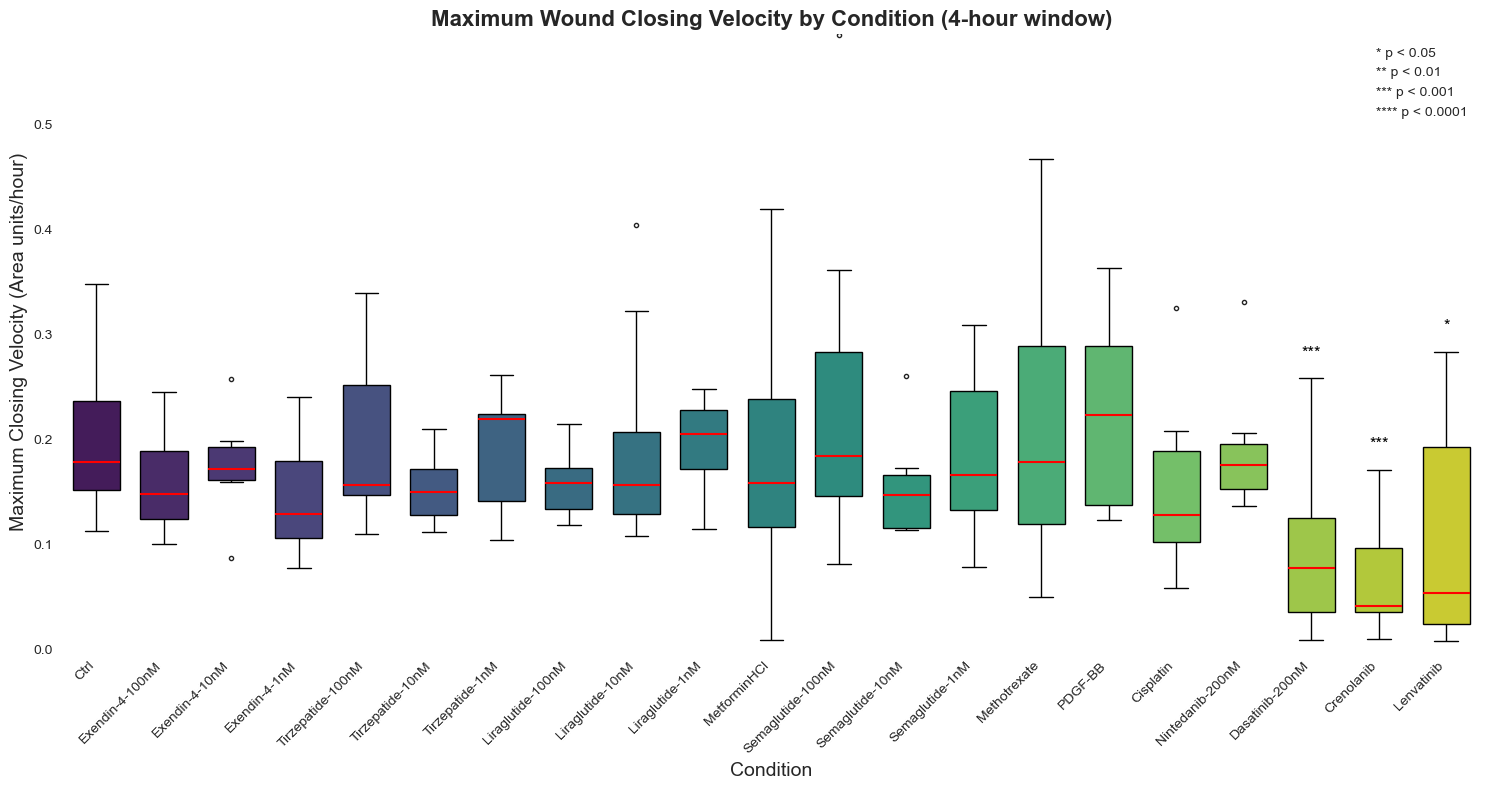


Summary of Maximum Wound Closing Velocity (area units/hour):
       Condition_Name  Mean_Velocity  Median_Velocity  StdDev_Velocity  \
2                Ctrl       0.198307         0.179030         0.067660   
5     Exendin-4-100nM       0.161070         0.148460         0.050857   
6      Exendin-4-10nM       0.174796         0.172382         0.055460   
7       Exendin-4-1nM       0.146211         0.129933         0.059993   
19  Tirzepatide-100nM       0.189898         0.157036         0.076440   
20   Tirzepatide-10nM       0.154115         0.150198         0.032368   
21    Tirzepatide-1nM       0.188490         0.220421         0.060397   
9   Liraglutide-100nM       0.158414         0.158936         0.031000   
10   Liraglutide-10nM       0.199755         0.156782         0.100988   
11    Liraglutide-1nM       0.196275         0.205668         0.044041   
12       MetforminHCl       0.182912         0.158886         0.101724   
16  Semaglutide-100nM       0.237460         0.184

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3130950576.py:196: FutureWarning: The provided callable <function nanmean at 0x000001FC149AE8E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_stats = velocity_df.groupby('Condition_Name').agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3130950576.py:196: FutureWarning: The provided callable <function nanmedian at 0x000001FC149AEC00> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_stats = velocity_df.groupby('Condition_Name').agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3130950576.py:196: FutureWarning: The provided callable <function nanstd at 0x000001FC149AF2E0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callab

In [15]:
# --- Calculate maximum closing velocity for each well using a 4-hour sliding window ---
def calculate_max_closing_velocity(well_data, window_size=4):
    """
    Calculate the maximum wound closing velocity using a sliding window.
    Returns the maximum rate of area change per hour (negative for closure).
    """
    # Sort data by time
    well_data = well_data.sort_values('Time (Hours)')

    # Need at least two time points
    if len(well_data) < 2:
        return np.nan, np.nan

    max_velocity = 0
    max_velocity_time = np.nan

    # Iterate through possible window start points
    for i in range(len(well_data) - 1):
        # Find end of window
        end_idx = i
        while (end_idx < len(well_data) - 1 and
               well_data.iloc[end_idx + 1]['Time (Hours)'] - well_data.iloc[i]['Time (Hours)'] <= window_size):
            end_idx += 1

        # Skip if window is too small
        if end_idx == i:
            continue

        # Calculate time difference
        start_time = well_data.iloc[i]['Time (Hours)']
        end_time = well_data.iloc[end_idx]['Time (Hours)']
        time_diff = end_time - start_time

        # Skip if time difference is too small
        if time_diff < 1:  # At least 1 hour to avoid extreme values from small time differences
            continue

        # Calculate area change
        start_area = well_data.iloc[i]['Area']
        end_area = well_data.iloc[end_idx]['Area']
        area_change = end_area - start_area

        # Calculate velocity (negative for closure, area/hour)
        velocity = area_change / time_diff

        # Update max velocity if more negative (faster closure)
        if velocity < max_velocity:
            max_velocity = velocity
            max_velocity_time = (start_time + end_time) / 2  # Midpoint of the window

    return max_velocity, max_velocity_time

# Create list to store maximum closing velocity for each well
max_velocities = []

for well_name in df_long['Well'].unique():
    well_data = df_long[df_long['Well'] == well_name]
    condition = well_data['Condition_Name'].iloc[0]
    max_velocity, max_velocity_time = calculate_max_closing_velocity(well_data)

    # Convert velocity to absolute value for easier interpretation
    # (more positive = faster closing)
    max_velocity_abs = -max_velocity if not np.isnan(max_velocity) else np.nan

    max_velocities.append({
        'Well': well_name,
        'Condition_Name': condition,
        'Max_Closing_Velocity': max_velocity_abs,
        'Time_of_Max_Velocity': max_velocity_time
    })

# Convert to DataFrame
velocity_df = pd.DataFrame(max_velocities)

# Get available conditions in order specified by user
available_conditions = set(velocity_df['Condition_Name'].unique())
ordered_conditions = [c for c in user_specified_condition_order if c in available_conditions]

# --- Perform statistical tests against Ctrl ---
p_values = {}
if 'Ctrl' in available_conditions:
    ctrl_data = velocity_df[velocity_df['Condition_Name'] == 'Ctrl']['Max_Closing_Velocity'].dropna()

    for condition in ordered_conditions:
        if condition != 'Ctrl':
            condition_data = velocity_df[velocity_df['Condition_Name'] == condition]['Max_Closing_Velocity'].dropna()
            if len(condition_data) > 0 and len(ctrl_data) > 0:
                stat, p_val = mannwhitneyu(condition_data, ctrl_data, alternative='two-sided')
                p_values[condition] = p_val
else:
    print("Warning: 'Ctrl' condition not found in the dataset")

# --- Create the box and whisker plot ---
plt.figure(figsize=(15, 8))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Filter data for ordered conditions
plot_data = velocity_df[velocity_df['Condition_Name'].isin(ordered_conditions)].copy()
plot_data['Condition_Name'] = pd.Categorical(
    plot_data['Condition_Name'],
    categories=ordered_conditions,
    ordered=True
)

# Create box plot
ax = sns.boxplot(
    x='Condition_Name',
    y='Max_Closing_Velocity',
    data=plot_data,
    palette='viridis',
    width=0.7,
    fliersize=3,
    linewidth=1,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    medianprops=dict(color='red', linewidth=1.5),
    capprops=dict(color='black'),
    showfliers=True
)

# Add only significant markers (no "ns")
def p_value_to_asterisks(p_val):
    if pd.isna(p_val):
        return ""
    if p_val < 0.0001:
        return "****"
    elif p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    return ""  # Return empty string instead of "ns" for non-significant values

# Get y-coordinate limits for annotations
whisker_tops = []
for i, condition in enumerate(ordered_conditions):
    condition_data = plot_data[plot_data['Condition_Name'] == condition]['Max_Closing_Velocity'].dropna()
    if len(condition_data) > 0:
        q3 = np.percentile(condition_data, 75)
        iqr = np.percentile(condition_data, 75) - np.percentile(condition_data, 25)
        upper_whisker = min(np.max(condition_data), q3 + 1.5 * iqr)
        whisker_tops.append(upper_whisker)
    else:
        whisker_tops.append(0)

# Find the maximum height for positioning annotations
y_max = max(whisker_tops) if whisker_tops else 0
y_offset = y_max * 0.05  # 5% of max for spacing

# Add significance markers above whiskers (only for significant conditions)
for i, condition in enumerate(ordered_conditions):
    if condition != 'Ctrl' and condition in p_values:
        p_val = p_values[condition]
        marker = p_value_to_asterisks(p_val)
        if marker:  # Only add if there's a significant marker to show
            plt.text(i, whisker_tops[i] + y_offset, marker,
                     ha='center', va='center', color='black', fontsize=12)

# Add a legend for significance
handles = [
    mpatches.Patch(color='none', label='* p < 0.05'),
    mpatches.Patch(color='none', label='** p < 0.01'),
    mpatches.Patch(color='none', label='*** p < 0.001'),
    mpatches.Patch(color='none', label='**** p < 0.0001')
]
plt.legend(handles=handles, loc='upper right', frameon=False)

# Format the plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Maximum Wound Closing Velocity by Condition (4-hour window)', fontsize=16, fontweight='bold')
plt.xlabel('Condition', fontsize=14)
plt.ylabel('Maximum Closing Velocity (Area units/hour)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add x and y axes lines
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add some buffer space at the top for annotations
plt.ylim(0, y_max * 1.2)
plt.tight_layout()

# Save and show the plot
plt.savefig('max_wound_closing_velocity_boxplot.png', dpi=300, bbox_inches='tight')
plt.savefig('max_wound_closing_velocity_boxplot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary of Maximum Wound Closing Velocity (area units/hour):")
summary_stats = velocity_df.groupby('Condition_Name').agg(
    Mean_Velocity=('Max_Closing_Velocity', np.nanmean),
    Median_Velocity=('Max_Closing_Velocity', np.nanmedian),
    StdDev_Velocity=('Max_Closing_Velocity', np.nanstd),
    Mean_Time_of_Max=('Time_of_Max_Velocity', np.nanmean),
    Count=('Max_Closing_Velocity', lambda x: np.sum(~np.isnan(x)))
).reset_index()

# Order and print summary statistics
ordered_summary = summary_stats[summary_stats['Condition_Name'].isin(ordered_conditions)].copy()
ordered_summary['Condition_Name'] = pd.Categorical(
    ordered_summary['Condition_Name'],
    categories=ordered_conditions,
    ordered=True
)
ordered_summary = ordered_summary.sort_values('Condition_Name')
print(ordered_summary[['Condition_Name', 'Mean_Velocity', 'Median_Velocity', 'StdDev_Velocity', 'Mean_Time_of_Max', 'Count']])

# Print statistical comparison results
if p_values:
    print("\nStatistical Comparisons (Mann-Whitney U Test vs 'Ctrl'):")
    for condition, p_val in sorted(p_values.items(), key=lambda x: ordered_conditions.index(x[0]) if x[0] in ordered_conditions else float('inf')):
        asterisks = p_value_to_asterisks(p_val)
        significance = f" {asterisks}" if asterisks else " (not significant)"
        print(f"- {condition} vs Ctrl: p = {p_val:.4f}{significance}")

# Report conditions that were explicitly dropped
print("\nThe following conditions were explicitly dropped from the analysis:")
for cond in conditions_to_drop:    print(f"- {cond}")

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3366406378.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


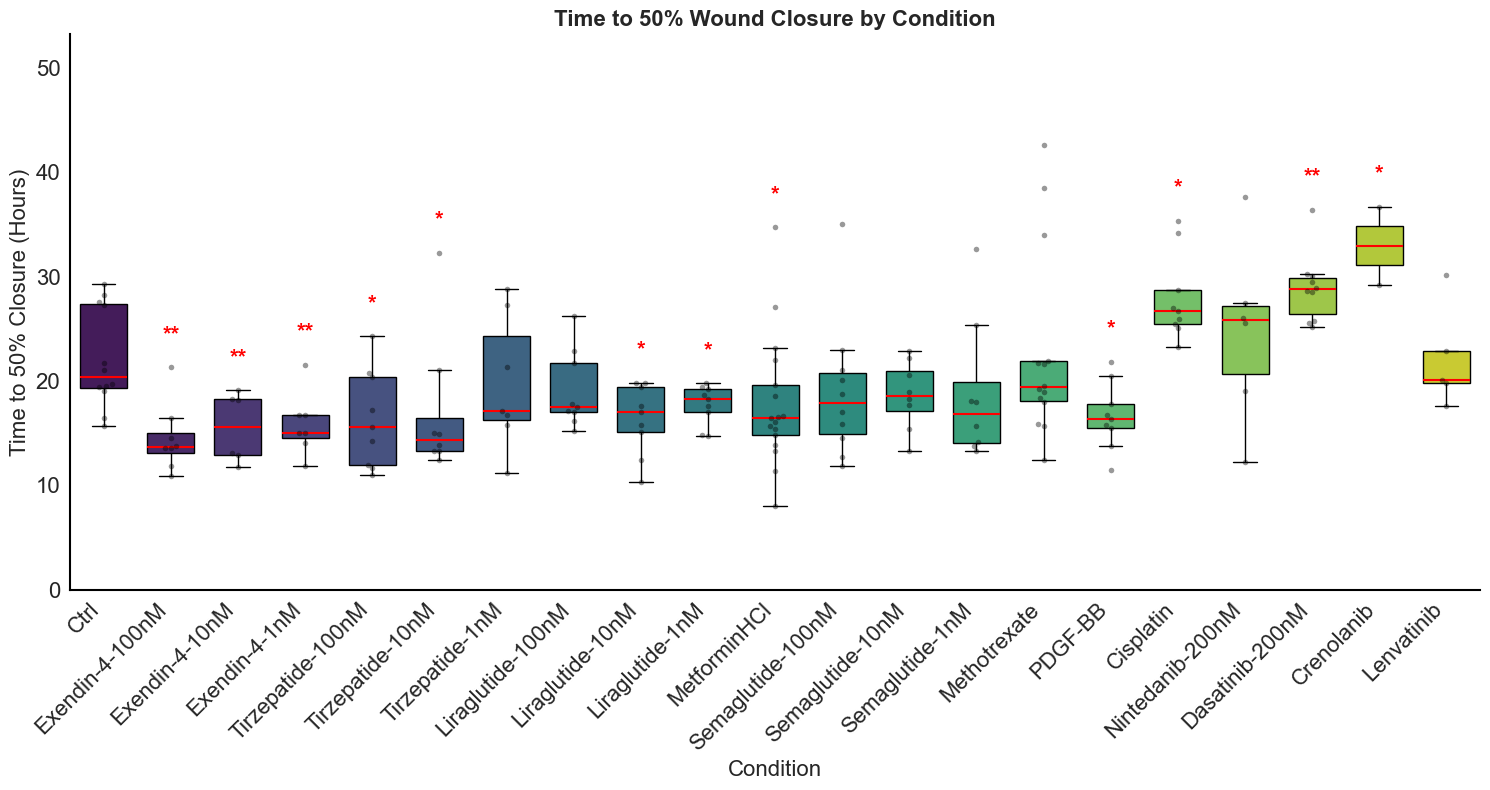


Summary of Time to 50% Wound Closure (hours):
       Condition_Name       Mean     Median    StdDev  Count  Total_Wells  \
2                Ctrl  22.085761  20.358014  4.766773     12           12   
5     Exendin-4-100nM  14.489995  13.673999  3.224044      8            8   
6      Exendin-4-10nM  15.545468  15.613099  3.305183      6            6   
7       Exendin-4-1nM  15.854987  15.034072  3.029577      7            7   
19  Tirzepatide-100nM  16.326771  15.553164  4.667245      9            9   
20   Tirzepatide-10nM  17.008452  14.383808  6.722422      8            8   
21    Tirzepatide-1nM  19.740988  17.075297  6.425132      7            7   
9   Liraglutide-100nM  19.066596  17.506132  3.671055      9            9   
10   Liraglutide-10nM  16.364212  16.977980  3.345778      9            9   
11    Liraglutide-1nM  17.716555  18.278409  1.906076      9            9   
12       MetforminHCl  17.831541  16.423545  6.256414     17           18   
16  Semaglutide-100nM  18.994

C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3366406378.py:165: FutureWarning: The provided callable <function nanmean at 0x000001FC149AE8E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_stats = closure_df.groupby('Condition_Name')['Time_to_50pct_Closure'].agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3366406378.py:165: FutureWarning: The provided callable <function nanmedian at 0x000001FC149AEC00> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_stats = closure_df.groupby('Condition_Name')['Time_to_50pct_Closure'].agg(
C:\Users\anish\AppData\Local\Temp\ipykernel_24472\3366406378.py:165: FutureWarning: The provided callable <function nanstd at 0x000001FC149AF2E0> is currently using SeriesGroupBy.std. In

In [16]:

# --- Calculate time to 50% wound closure for each well ---
def calculate_time_to_closure(well_data, threshold=0.5):
    """
    Calculate the time point at which the wound area drops below the threshold.
    Returns np.nan if the threshold is never reached.
    """
    well_data = well_data.sort_values('Time (Hours)')
    if not any(well_data['Area'] <= threshold):
        return np.nan
    first_below = well_data[well_data['Area'] <= threshold].iloc[0]
    if well_data.iloc[0]['Area'] <= threshold:
        return first_below['Time (Hours)']

    well_data_sorted_index = well_data.sort_index()
    last_above_series = well_data_sorted_index[well_data_sorted_index['Area'] > threshold]
    if last_above_series.empty:
        return np.nan
    last_above_idx = last_above_series.index[-1]
    last_above = well_data.loc[last_above_idx]

    time_before = last_above['Time (Hours)']
    area_before = last_above['Area']
    time_after = first_below['Time (Hours)']
    area_after = first_below['Area']

    if area_before == area_after:
        return time_before
    fraction = (threshold - area_before) / (area_after - area_before)
    interpolated_time = time_before + fraction * (time_after - time_before)
    return interpolated_time

closure_times = []
for well_name in df_long['Well'].unique():
    well_data = df_long[df_long['Well'] == well_name]
    condition = well_data['Condition_Name'].iloc[0]
    time_to_closure = calculate_time_to_closure(well_data)
    closure_times.append({
        'Well': well_name,
        'Condition_Name': condition,
        'Time_to_50pct_Closure': time_to_closure
    })
closure_df = pd.DataFrame(closure_times)

available_conditions = set(closure_df['Condition_Name'].unique())
ordered_conditions = [c for c in user_specified_condition_order if c in available_conditions]

p_values = {}
if 'Ctrl' in available_conditions:
    ctrl_data = closure_df[closure_df['Condition_Name'] == 'Ctrl']['Time_to_50pct_Closure'].dropna()
    for condition in ordered_conditions:
        if condition != 'Ctrl':
            cond_data = closure_df[closure_df['Condition_Name'] == condition]['Time_to_50pct_Closure'].dropna()
            if len(cond_data) > 1 and len(ctrl_data) > 1: # Mann-Whitney U requires at least 2 samples in each group
                try:
                    stat, p = mannwhitneyu(cond_data, ctrl_data, alternative='two-sided')
                    p_values[condition] = p
                except ValueError:
                    p_values[condition] = np.nan
            else:
                p_values[condition] = np.nan
else:
    print("Warning: 'Ctrl' condition not found for statistical tests.")

plt.figure(figsize=(15, 8))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

plot_data = closure_df[closure_df['Condition_Name'].isin(ordered_conditions)].copy()
plot_data['Condition_Name'] = pd.Categorical(plot_data['Condition_Name'], categories=ordered_conditions, ordered=True)

ax = sns.boxplot(
    x='Condition_Name',
    y='Time_to_50pct_Closure',
    data=plot_data,
    palette='viridis',
    width=0.7,
    fliersize=0,
    linewidth=1,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    medianprops=dict(color='red', linewidth=1.5),
    capprops=dict(color='black'),
    showfliers=False
)
sns.swarmplot(
    x='Condition_Name',
    y='Time_to_50pct_Closure',
    data=plot_data,
    color='black',
    size=4,
    alpha=0.4,
    dodge=True,
    ax=ax
)

def p_value_to_asterisks(p_val):
    if pd.isna(p_val): return ""
    if p_val < 0.0001: return "****"
    elif p_val < 0.001: return "***"
    elif p_val < 0.01: return "**"
    elif p_val < 0.05: return "*"
    return ""

whisker_tops = []
all_y_values = []
for i, condition in enumerate(ordered_conditions):
    condition_data = plot_data[plot_data['Condition_Name'] == condition]['Time_to_50pct_Closure'].dropna()
    if len(condition_data) > 0:
        all_y_values.extend(condition_data.tolist())
        q1 = np.percentile(condition_data, 25)
        q3 = np.percentile(condition_data, 75)
        iqr = q3 - q1
        upper_whisker = min(np.max(condition_data), q3 + 1.5 * iqr)
        # Use the maximum of actual data points for annotation base if swarmplot is used
        whisker_tops.append(np.max(condition_data))
    else:
        whisker_tops.append(0)

y_max_plot = max(all_y_values) if all_y_values else (max(whisker_tops) if whisker_tops else 0)
y_offset = y_max_plot * 0.05

for i, condition in enumerate(ordered_conditions):
    if condition != 'Ctrl' and condition in p_values:
        p_val = p_values[condition]
        marker = p_value_to_asterisks(p_val)
        if marker:
            y_pos = whisker_tops[i] + y_offset
            # Adjust y_pos if it's too close to other annotations or plot elements
            # This might require a more sophisticated logic if overlaps are common
            plt.text(i, y_pos, marker, ha='center', va='bottom', fontsize=16, fontweight='bold', color='red')

handles = [
    mpatches.Patch(color='none', label='* p < 0.05'),
    mpatches.Patch(color='none', label='** p < 0.01'),
    mpatches.Patch(color='none', label='*** p < 0.001'),
    mpatches.Patch(color='none', label='**** p < 0.0001')
]
# plt.legend(handles=handles, loc='upper right', frameon=False) # Legend commented out as per active code

plt.xticks(rotation=45, ha='right', fontsize=16) # Fontsize from active code
plt.title('Time to 50% Wound Closure by Condition', fontsize=16, fontweight='bold')
plt.xlabel('Condition', fontsize=16) # Fontsize from active code
plt.ylabel('Time to 50% Closure (Hours)', fontsize=16) # Fontsize from active code
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.yticks(fontsize=16) # Fontsize from active code

# Add x and y axes lines, ensuring they are black and visible
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim(0, y_max_plot * 1.25) # Increased buffer slightly for annotations
plt.tight_layout()

plt.savefig('time_to_50pct_wound_closure_boxplot_axes_black.png', dpi=300, bbox_inches='tight')
plt.savefig('time_to_50pct_wound_closure_boxplot_axes_black.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

print("\nSummary of Time to 50% Wound Closure (hours):")
summary_stats = closure_df.groupby('Condition_Name')['Time_to_50pct_Closure'].agg(
    Mean=np.nanmean,
    Median=np.nanmedian,
    StdDev=np.nanstd,
    Count=lambda x: np.sum(~np.isnan(x)),
    Total_Wells=lambda x: len(x)
).reset_index()
summary_stats['% Wells Reaching 50%'] = (summary_stats['Count'] / summary_stats['Total_Wells'] * 100).round(1)

ordered_summary = summary_stats[summary_stats['Condition_Name'].isin(ordered_conditions)].copy()
ordered_summary['Condition_Name'] = pd.Categorical(ordered_summary['Condition_Name'], categories=ordered_conditions, ordered=True)
ordered_summary = ordered_summary.sort_values('Condition_Name')
print(ordered_summary[['Condition_Name', 'Mean', 'Median', 'StdDev', 'Count', 'Total_Wells', '% Wells Reaching 50%']])

if p_values:
    print("\nStatistical Comparisons (Mann-Whitney U Test vs 'Ctrl'):")
    sorted_p_values_items = sorted(p_values.items(), key=lambda item: ordered_conditions.index(item[0]) if item[0] in ordered_conditions else float('inf'))
    for condition, p_val in sorted_p_values_items:
        if condition == 'Ctrl':
            continue
        asterisks = p_value_to_asterisks(p_val)
        if pd.notna(p_val):
            print(f"- {condition} vs Ctrl: p = {p_val:.4f}{(' ' + asterisks) if asterisks else ' (not significant)'}")
        else:
            print(f"- {condition} vs Ctrl: Insufficient data for comparison")

# if 'conditions_to_drop' in globals() and conditions_to_drop: # From previous context
#     print("\nThe following conditions were explicitly dropped from the analysis:")
#     for cond in conditions_to_drop:
#         print(f"- {cond}")

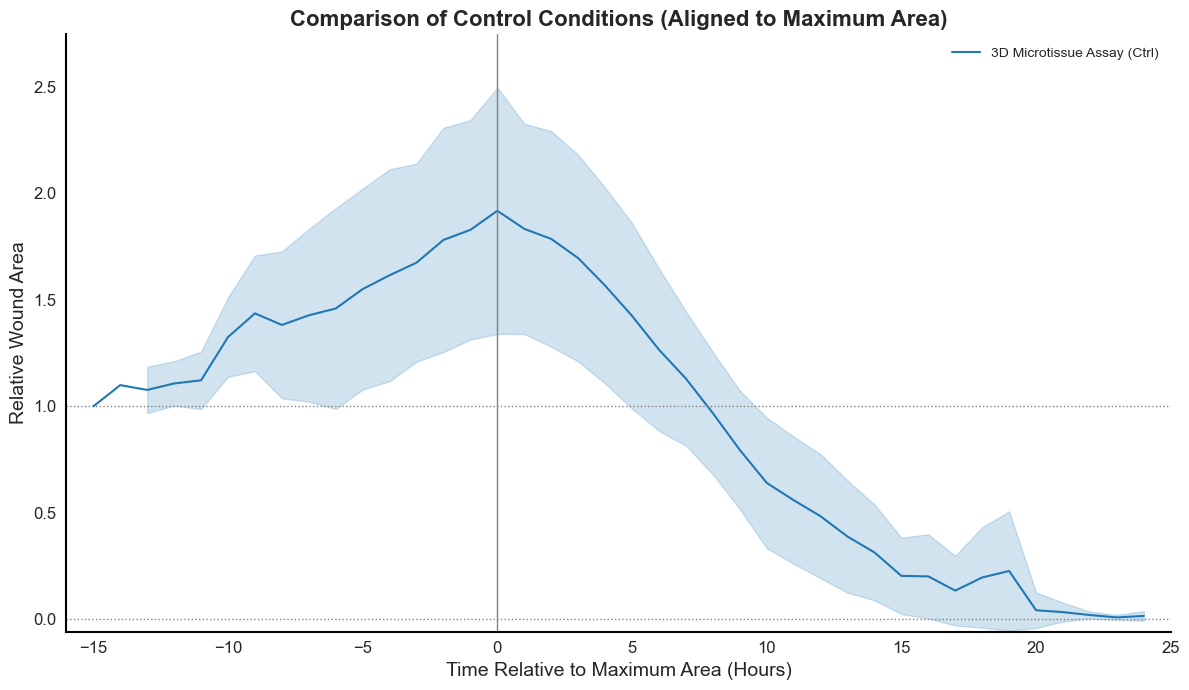

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Data Loading and Preparation for D34567 (3D Microtissue Assay) ---
file_path_d3 = 'D:\\PythonProjects\\DataPlotting\\Data\\D34567.xlsx'

def extract_condition_name_d3(sample_name):
    """Extracts condition name for D34567 data."""
    full_match = re.match(r'([A-Za-z0-9\-]+(?:-[0-9\.]+nM)?)', sample_name)
    if full_match:
        return full_match.group(1)
    simple_match = re.match(r'([^_]+)', sample_name)
    if simple_match:
        return simple_match.group(1)
    return sample_name

try:
    # Load 3D Microtissue data
    df_excel_d3 = pd.read_excel(file_path_d3, sheet_name='Normalized')
    treatment_conditions_d3 = df_excel_d3.columns[1:].tolist()
    time_data_d3 = df_excel_d3.iloc[:, 0]
    wound_area_data_d3 = df_excel_d3.iloc[:, 1:]
    wound_area_df_d3 = pd.DataFrame(wound_area_data_d3.values, columns=treatment_conditions_d3, index=time_data_d3)
    wound_area_df_d3.index.name = 'Time (Hours)'

    # Convert to long format
    df_long_d3 = wound_area_df_d3.reset_index().melt(
        id_vars=['Time (Hours)'],
        var_name='Well',
        value_name='Area'
    )
    df_long_d3['Condition_Name'] = df_long_d3['Well'].apply(extract_condition_name_d3)

    # Truncate at 30 hours
    df_long_d3_truncated = df_long_d3[df_long_d3['Time (Hours)'] <= 30].copy()

    # Keep only control data for D34567
    ctrl_data_d3 = df_long_d3_truncated[df_long_d3_truncated['Condition_Name'] == 'Ctrl'].copy()

    # For each well, find the time of maximum wound area and shift the time axis
    max_aligned_d3_data = []

    for well in ctrl_data_d3['Well'].unique():
        well_data = ctrl_data_d3[ctrl_data_d3['Well'] == well].copy()
        if well_data.empty:
            continue

        # Find the time at maximum area
        max_area_idx = well_data['Area'].idxmax()
        max_area_time = well_data.loc[max_area_idx, 'Time (Hours)']

        # Create time-shifted data
        well_data['Aligned_Time'] = well_data['Time (Hours)'] - max_area_time
        max_aligned_d3_data.append(well_data)

    # Combine all aligned data
    aligned_ctrl_d3 = pd.concat(max_aligned_d3_data) if max_aligned_d3_data else pd.DataFrame()

    # Calculate mean and std for aligned data
    if not aligned_ctrl_d3.empty:
        # Group by the aligned time and calculate statistics
        grouped_d3 = aligned_ctrl_d3.groupby('Aligned_Time')['Area'].agg(['mean', 'std']).reset_index()
        mean_ctrl_d3_aligned = pd.Series(grouped_d3['mean'].values, index=grouped_d3['Aligned_Time'])
        std_ctrl_d3_aligned = pd.Series(grouped_d3['std'].values, index=grouped_d3['Aligned_Time'])
    else:
        mean_ctrl_d3_aligned = pd.Series(dtype=float)
        std_ctrl_d3_aligned = pd.Series(dtype=float)

except FileNotFoundError:
    print(f"Error: File not found at '{file_path_d3}'. Please check the path.")
    mean_ctrl_d3_aligned = pd.Series(dtype=float)
    std_ctrl_d3_aligned = pd.Series(dtype=float)
except Exception as e:
    print(f"An error occurred while processing '{file_path_d3}': {e}")
    mean_ctrl_d3_aligned = pd.Series(dtype=float)
    std_ctrl_d3_aligned = pd.Series(dtype=float)


# --- Plotting ---
plt.figure(figsize=(12, 7))
ax = plt.gca()

# Plot D34567 (3D Microtissue Assay) - Max-Aligned
if not mean_ctrl_d3_aligned.empty:
    line_d3, = ax.plot(mean_ctrl_d3_aligned.index, mean_ctrl_d3_aligned, label='3D Microtissue Assay (Ctrl)')
    color_d3 = line_d3.get_color()
    ax.fill_between(mean_ctrl_d3_aligned.index,
                     mean_ctrl_d3_aligned - std_ctrl_d3_aligned,
                     mean_ctrl_d3_aligned + std_ctrl_d3_aligned,
                     alpha=0.2, color=color_d3)


# Plot Customization
plt.title('Comparison of Control Conditions (Aligned to Maximum Area)', fontsize=16, fontweight='bold')
plt.xlabel('Time Relative to Maximum Area (Hours)', fontsize=14)
plt.ylabel('Relative Wound Area', fontsize=14)

if not mean_ctrl_d3_aligned.empty or not mean_ctrl_sw_aligned.empty:
    plt.legend(frameon=False)

plt.grid(True, linestyle='--', alpha=0.6)
ax.axhline(1.0, color='grey', linestyle=':', linewidth=1)
ax.axhline(0.0, color='grey', linestyle=':', linewidth=1)
ax.axvline(0.0, color='grey', linestyle='-', linewidth=1)

ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Calculate appropriate y-axis limits
min_y_val = 0
max_y_val = 1.0

# Check D3 data for min/max
if not mean_ctrl_d3_aligned.empty:
    min_d3 = (mean_ctrl_d3_aligned - std_ctrl_d3_aligned).min() if not std_ctrl_d3_aligned.empty else mean_ctrl_d3_aligned.min()
    max_d3 = (mean_ctrl_d3_aligned + std_ctrl_d3_aligned).max() if not std_ctrl_d3_aligned.empty else mean_ctrl_d3_aligned.max()
    min_y_val = min(min_y_val, min_d3)
    max_y_val = max(max_y_val, max_d3)


# Set y-axis limits with padding
min_y_limit = min_y_val * 1.1 if min_y_val < 0 else -0.05
plt.ylim(min_y_limit, max_y_val * 1.1)

# Set appropriate x-axis limits
all_times = []
if not mean_ctrl_d3_aligned.empty:
    all_times.extend(mean_ctrl_d3_aligned.index.tolist())


if all_times:
    min_time = min(all_times)
    max_time = max(all_times)
    plt.xlim(min_time - 1, max_time + 1)  # Add padding

plt.tight_layout()
plt.savefig('control_comparison_max_aligned_30h.png', dpi=300, bbox_inches='tight')
plt.savefig('control_comparison_max_aligned_30h.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

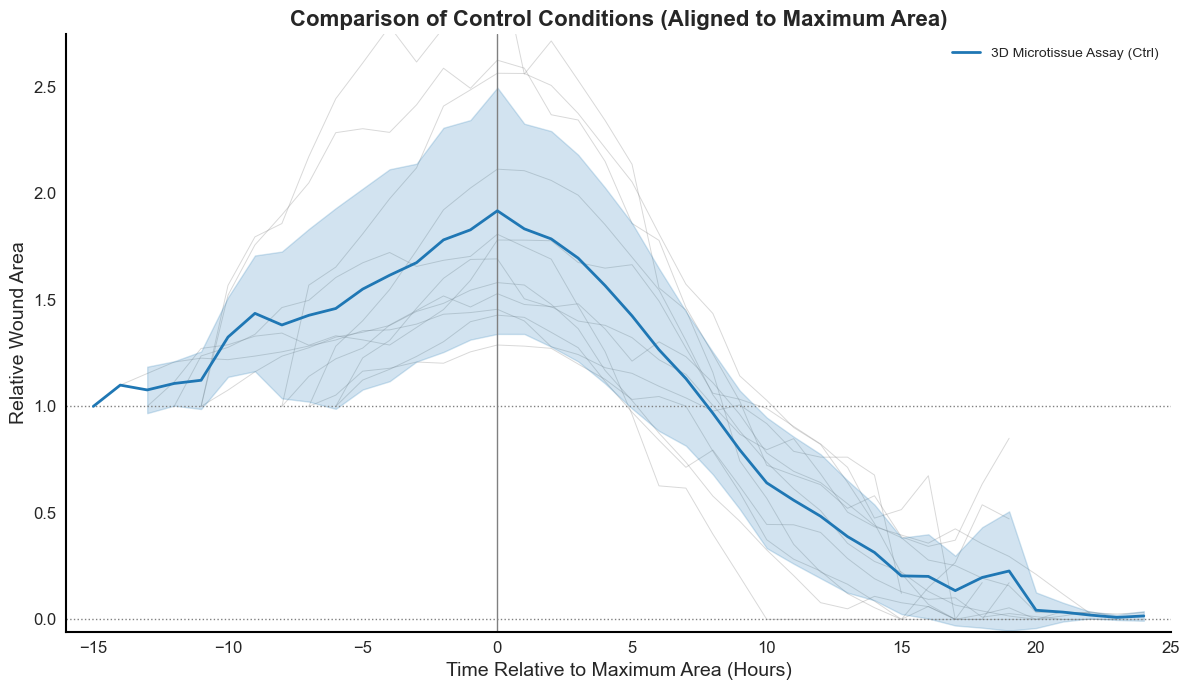

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Data Loading and Preparation for D34567 (3D Microtissue Assay) ---
file_path_d3 = 'D:\\PythonProjects\\DataPlotting\\Data\\D34567.xlsx'

def extract_condition_name_d3(sample_name):
    """Extracts condition name for D34567 data."""
    full_match = re.match(r'([A-Za-z0-9\-]+(?:-[0-9\.]+nM)?)', sample_name)
    if full_match:
        return full_match.group(1)
    simple_match = re.match(r'([^_]+)', sample_name)
    if simple_match:
        return simple_match.group(1)
    return sample_name

try:
    # Load 3D Microtissue data
    df_excel_d3 = pd.read_excel(file_path_d3, sheet_name='Normalized')
    treatment_conditions_d3 = df_excel_d3.columns[1:].tolist()
    time_data_d3 = df_excel_d3.iloc[:, 0]
    wound_area_data_d3 = df_excel_d3.iloc[:, 1:]
    wound_area_df_d3 = pd.DataFrame(wound_area_data_d3.values, columns=treatment_conditions_d3, index=time_data_d3)
    wound_area_df_d3.index.name = 'Time (Hours)'

    # Convert to long format
    df_long_d3 = wound_area_df_d3.reset_index().melt(
        id_vars=['Time (Hours)'],
        var_name='Well',
        value_name='Area'
    )
    df_long_d3['Condition_Name'] = df_long_d3['Well'].apply(extract_condition_name_d3)

    # Truncate at 30 hours
    df_long_d3_truncated = df_long_d3[df_long_d3['Time (Hours)'] <= 30].copy()

    # Keep only control data for D34567
    ctrl_data_d3 = df_long_d3_truncated[df_long_d3_truncated['Condition_Name'] == 'Ctrl'].copy()

    # For each well, find the time of maximum wound area and shift the time axis
    max_aligned_d3_data = []

    for well in ctrl_data_d3['Well'].unique():
        well_data = ctrl_data_d3[ctrl_data_d3['Well'] == well].copy()
        if well_data.empty:
            continue

        # Find the time at maximum area
        max_area_idx = well_data['Area'].idxmax()
        max_area_time = well_data.loc[max_area_idx, 'Time (Hours)']

        # Create time-shifted data
        well_data['Aligned_Time'] = well_data['Time (Hours)'] - max_area_time
        max_aligned_d3_data.append(well_data)

    # Combine all aligned data
    aligned_ctrl_d3 = pd.concat(max_aligned_d3_data) if max_aligned_d3_data else pd.DataFrame()

    # Calculate mean and std for aligned data
    if not aligned_ctrl_d3.empty:
        # Group by the aligned time and calculate statistics
        grouped_d3 = aligned_ctrl_d3.groupby('Aligned_Time')['Area'].agg(['mean', 'std']).reset_index()
        mean_ctrl_d3_aligned = pd.Series(grouped_d3['mean'].values, index=grouped_d3['Aligned_Time'])
        std_ctrl_d3_aligned = pd.Series(grouped_d3['std'].values, index=grouped_d3['Aligned_Time'])
    else:
        mean_ctrl_d3_aligned = pd.Series(dtype=float)
        std_ctrl_d3_aligned = pd.Series(dtype=float)

except FileNotFoundError:
    print(f"Error: File not found at '{file_path_d3}'. Please check the path.")
    mean_ctrl_d3_aligned = pd.Series(dtype=float)
    std_ctrl_d3_aligned = pd.Series(dtype=float)
    aligned_ctrl_d3 = pd.DataFrame()
except Exception as e:
    print(f"An error occurred while processing '{file_path_d3}': {e}")
    mean_ctrl_d3_aligned = pd.Series(dtype=float)
    std_ctrl_d3_aligned = pd.Series(dtype=float)
    aligned_ctrl_d3 = pd.DataFrame()

# --- Plotting ---
plt.figure(figsize=(12, 7))
ax = plt.gca()

# First plot individual aligned samples as light grey lines
if not aligned_ctrl_d3.empty:
    for well, well_data in aligned_ctrl_d3.groupby('Well'):
        # Sort by aligned time to ensure proper line plotting
        well_data = well_data.sort_values('Aligned_Time')
        # Plot each well as a light grey line with transparency
        ax.plot(well_data['Aligned_Time'], well_data['Area'],
                color='grey', alpha=0.3, linewidth=0.7, zorder=1)

# Then plot D34567 (3D Microtissue Assay) mean and std - Max-Aligned
if not mean_ctrl_d3_aligned.empty:
    line_d3, = ax.plot(mean_ctrl_d3_aligned.index, mean_ctrl_d3_aligned,
                      label='3D Microtissue Assay (Ctrl)', linewidth=2, zorder=3)
    color_d3 = line_d3.get_color()
    ax.fill_between(mean_ctrl_d3_aligned.index,
                     mean_ctrl_d3_aligned - std_ctrl_d3_aligned,
                     mean_ctrl_d3_aligned + std_ctrl_d3_aligned,
                     alpha=0.2, color=color_d3, zorder=2)

# Plot Customization
plt.title('Comparison of Control Conditions (Aligned to Maximum Area)', fontsize=16, fontweight='bold')
plt.xlabel('Time Relative to Maximum Area (Hours)', fontsize=14)
plt.ylabel('Relative Wound Area', fontsize=14)

if not mean_ctrl_d3_aligned.empty:
    plt.legend(frameon=False)

plt.grid(True, linestyle='--', alpha=0.6)
ax.axhline(1.0, color='grey', linestyle=':', linewidth=1)
ax.axhline(0.0, color='grey', linestyle=':', linewidth=1)
ax.axvline(0.0, color='grey', linestyle='-', linewidth=1)

ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Calculate appropriate y-axis limits
min_y_val = 0
max_y_val = 1.0

# Check D3 data for min/max
if not mean_ctrl_d3_aligned.empty:
    min_d3 = (mean_ctrl_d3_aligned - std_ctrl_d3_aligned).min() if not std_ctrl_d3_aligned.empty else mean_ctrl_d3_aligned.min()
    max_d3 = (mean_ctrl_d3_aligned + std_ctrl_d3_aligned).max() if not std_ctrl_d3_aligned.empty else mean_ctrl_d3_aligned.max()
    min_y_val = min(min_y_val, min_d3)
    max_y_val = max(max_y_val, max_d3)

# Set y-axis limits with padding
min_y_limit = min_y_val * 1.1 if min_y_val < 0 else -0.05
plt.ylim(min_y_limit, max_y_val * 1.1)

# Set appropriate x-axis limits
all_times = []
if not mean_ctrl_d3_aligned.empty:
    all_times.extend(mean_ctrl_d3_aligned.index.tolist())

if all_times:
    min_time = min(all_times)
    max_time = max(all_times)
    plt.xlim(min_time - 1, max_time + 1)  # Add padding

plt.tight_layout()
plt.savefig('control_comparison_max_aligned_30h_with_individual_lines.png', dpi=300, bbox_inches='tight')
plt.savefig('control_comparison_max_aligned_30h_with_individual_lines.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

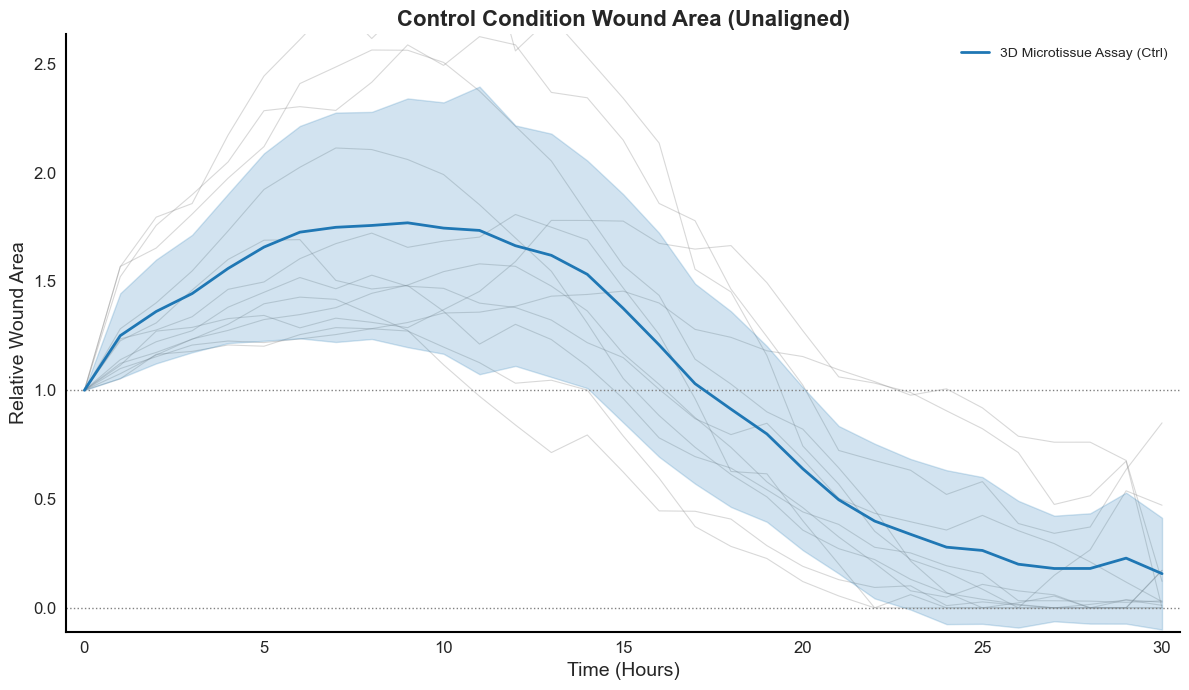

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Data Loading and Preparation for D34567 (3D Microtissue Assay) ---
file_path_d3 = 'D:\\PythonProjects\\DataPlotting\\Data\\D34567.xlsx'

def extract_condition_name_d3(sample_name):
    """Extracts condition name for D34567 data."""
    full_match = re.match(r'([A-Za-z0-9\-]+(?:-[0-9\.]+nM)?)', sample_name)
    if full_match:
        return full_match.group(1)
    simple_match = re.match(r'([^_]+)', sample_name)
    if simple_match:
        return simple_match.group(1)
    return sample_name

try:
    # Load 3D Microtissue data
    df_excel_d3 = pd.read_excel(file_path_d3, sheet_name='Normalized')
    treatment_conditions_d3 = df_excel_d3.columns[1:].tolist()
    time_data_d3 = df_excel_d3.iloc[:, 0]
    wound_area_data_d3 = df_excel_d3.iloc[:, 1:]
    wound_area_df_d3 = pd.DataFrame(wound_area_data_d3.values, columns=treatment_conditions_d3, index=time_data_d3)
    wound_area_df_d3.index.name = 'Time (Hours)'

    # Convert to long format
    df_long_d3 = wound_area_df_d3.reset_index().melt(
        id_vars=['Time (Hours)'],
        var_name='Well',
        value_name='Area'
    )
    df_long_d3['Condition_Name'] = df_long_d3['Well'].apply(extract_condition_name_d3)

    # Truncate at 30 hours
    df_long_d3_truncated = df_long_d3[df_long_d3['Time (Hours)'] <= 30].copy()

    # Keep only control data for D34567
    ctrl_data_d3 = df_long_d3_truncated[df_long_d3_truncated['Condition_Name'] == 'Ctrl'].copy()

    # Calculate mean and std for unaligned data
    if not ctrl_data_d3.empty:
        grouped_d3 = ctrl_data_d3.groupby('Time (Hours)')['Area'].agg(['mean', 'std']).reset_index()
        mean_ctrl_d3 = pd.Series(grouped_d3['mean'].values, index=grouped_d3['Time (Hours)'])
        std_ctrl_d3 = pd.Series(grouped_d3['std'].values, index=grouped_d3['Time (Hours)'])
    else:
        mean_ctrl_d3 = pd.Series(dtype=float)
        std_ctrl_d3 = pd.Series(dtype=float)

except FileNotFoundError:
    print(f"Error: File not found at '{file_path_d3}'. Please check the path.")
    mean_ctrl_d3 = pd.Series(dtype=float)
    std_ctrl_d3 = pd.Series(dtype=float)
    ctrl_data_d3 = pd.DataFrame()
except Exception as e:
    print(f"An error occurred while processing '{file_path_d3}': {e}")
    mean_ctrl_d3 = pd.Series(dtype=float)
    std_ctrl_d3 = pd.Series(dtype=float)
    ctrl_data_d3 = pd.DataFrame()

# --- Plotting ---
plt.figure(figsize=(12, 7))
ax = plt.gca()

# First plot individual unaligned samples as light grey lines
if not ctrl_data_d3.empty:
    for well, well_data in ctrl_data_d3.groupby('Well'):
        # Sort by time to ensure proper line plotting
        well_data = well_data.sort_values('Time (Hours)')
        # Plot each well as a light grey line with transparency
        ax.plot(well_data['Time (Hours)'], well_data['Area'],
                color='grey', alpha=0.3, linewidth=0.8, zorder=1)

# Then plot D34567 (3D Microtissue Assay) mean and std - Unaligned
if not mean_ctrl_d3.empty:
    line_d3, = ax.plot(mean_ctrl_d3.index, mean_ctrl_d3,
                      label='3D Microtissue Assay (Ctrl)', linewidth=2, zorder=3)
    color_d3 = line_d3.get_color()
    ax.fill_between(mean_ctrl_d3.index,
                     mean_ctrl_d3 - std_ctrl_d3,
                     mean_ctrl_d3 + std_ctrl_d3,
                     alpha=0.2, color=color_d3, zorder=2)

# Plot Customization
plt.title('Control Condition Wound Area (Unaligned)', fontsize=16, fontweight='bold')
plt.xlabel('Time (Hours)', fontsize=14)
plt.ylabel('Relative Wound Area', fontsize=14)

if not mean_ctrl_d3.empty:
    plt.legend(frameon=False)

plt.grid(True, linestyle='--', alpha=0.6)
ax.axhline(1.0, color='grey', linestyle=':', linewidth=1)
ax.axhline(0.0, color='grey', linestyle=':', linewidth=1)

ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Calculate appropriate y-axis limits
min_y_val = 0
max_y_val = 1.0

# Check D3 data for min/max
if not mean_ctrl_d3.empty:
    min_d3 = (mean_ctrl_d3 - std_ctrl_d3).min() if not std_ctrl_d3.empty else mean_ctrl_d3.min()
    max_d3 = (mean_ctrl_d3 + std_ctrl_d3).max() if not std_ctrl_d3.empty else mean_ctrl_d3.max()
    min_y_val = min(min_y_val, min_d3)
    max_y_val = max(max_y_val, max_d3)

# Set y-axis limits with padding
min_y_limit = min_y_val * 1.1 if min_y_val < 0 else -0.05
plt.ylim(min_y_limit, max_y_val * 1.1)

# Set appropriate x-axis limits (for unaligned data, start at 0)
plt.xlim(-0.5, 30.5)  # Add slight padding

plt.tight_layout()
plt.savefig('control_unaligned_30h_with_individual_lines.png', dpi=300, bbox_inches='tight')
plt.savefig('control_unaligned_30h_with_individual_lines.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Make ridge plots of all conditions. Each condition should be on its own line. The shared x-axis is time in hours.



